# Воробьев А. С. (DSU-31). 
## Дипломная работа на тему: "Детекция и классификация марок и моделей автомобиля на изображении" 
### Датасет - https://universe.roboflow.com/mxk/car-model-detection/dataset/1

In [1]:
import os
import gc
import cv2
import wget
import json
import glob
import random
import time
import tensorboard
import pandas as pd
import collections

import torch
import torch.optim
import torch.utils.data
import torch.nn.functional as F
import torchvision
import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as FT

import matplotlib.pyplot as plt
import matplotlib as mpl
import PIL
import seaborn as sns
%matplotlib inline

from pylabel import importer
from ultralytics import YOLO
from PIL import Image, ImageDraw, ImageFont
from xml.dom import minidom
from xml.etree import ElementTree as ET
from torch.backends import cuda, mps, cudnn
from torch.utils.data import Dataset
from torch import nn
from utils import *
from math import sqrt
from itertools import product as product
from tqdm import tqdm
from pprint import PrettyPrinter


In [2]:
import warnings

warnings.filterwarnings("ignore", category=UserWarning)

In [3]:
print(f"PyTorch version: {torch.__version__}")

# Check PyTorch has access to MPS (Metal Performance Shader, Apple's GPU architecture)
print(f"Is MPS built? {mps.is_built()}")
print(f"Is MPS available? {mps.is_available()}")

# Check PyTorch has access to CUDA (NVIDIA GPU architecture)
print(f"Is CUDA built? {cuda.is_built()}")
print(f"Is CUDA available? {torch.cuda.is_available()}")

# Set the device
if mps.is_available():
    device = "mps"
elif torch.cuda.is_available():
    device = "cuda"
    CUDA_LAUNCH_BLOCKING = "1"
else:
    "cpu"

print(f"Using device: {device}")

PyTorch version: 2.2.2+cu118
Is MPS built? False
Is MPS available? False
Is CUDA built? True
Is CUDA available? True
Using device: cuda


In [5]:
base_path_10_car_model = "G:/Code/Netology/Python/DS/Диплом/Dataset/data_car_model_10_detection.voc"

bp_train_10_car_model = 'G:/Code/Netology/Python/DS/Диплом/Dataset/data_car_model_10_detection.voc/train/'
bp_valid_10_car_model = 'G:/Code/Netology/Python/DS/Диплом/Dataset/data_car_model_10_detection.voc/valid/'

core_dir = 'G:/Code/Netology/Python/DS/Диплом/Dataset/'

input_dir_tr = bp_train_10_car_model + "annotations/xmls/"
output_dir_tr = bp_train_10_car_model + "labels/"
image_dir_tr = bp_train_10_car_model + "images/"

input_dir_val = bp_valid_10_car_model + "annotations/xmls/"
output_dir_val = bp_valid_10_car_model + "labels/"
image_dir_val = bp_valid_10_car_model + "images/"

base_path_SSD300_10_car_model = "G:/Code/Netology/Python/DS/Диплом/Dataset/data_car_model_10_detection.voc/for_SSD300"

SSD300_imgset = base_path_SSD300_10_car_model + '/ImageSets'
SSD300_jpg_img = base_path_SSD300_10_car_model + '/JPEGImages'

cls_data = ['train', 'valid']

### 1. Анализ данных

In [6]:
# Количество фотографий и размеченных объектов на фото в TRAIN и VALID датасете
cls_names = []
total_images = 0

for cls in cls_data:
    cnt = 0
    file_list = [
        filename
        for filename in os.listdir(base_path_10_car_model + '/' + str(cls[cnt:]) + "/annotations/xmls/")
        if not filename.startswith(".")
    ]

    for file in file_list:
        total_images += 1
        if file == ".DS_Store":
            pass
        else:
            infile_xml = open(base_path_10_car_model + '/' + str(cls[cnt:]) + "/annotations/xmls/" + file)
            tree = ET.parse(infile_xml)
            root = tree.getroot()
            for obj in root.iter("object"):
                cls_name = obj.find("name").text
                cls_names.append(cls_name)
    
    cnt += 1

print("total TRAIN/VALID")
print("# of images：" + str(total_images))
print("# of labels：" + str(len(cls_names)))

total TRAIN/VALID
# of images：8132
# of labels：8132


In [7]:
# Распределение авто (марки, модели, год) по классам в размеченном (train/val) датасете.
# Примечание: количество рассчитывается только по тем типам авто, которые указаны в списке "cls_names"!
count_dict = collections.Counter(cls_names)
cls_count = []
for carType in cls_names:
    print(str(carType) + " : " + str(count_dict[carType]))
    cls_count.append(count_dict[carType])

sns.set_palette("winter")
try:
    ax = sns.barplot(cls_names, cls_count)
except TypeError:
    next

Audi TTS Coupe 2012 : 41
Acura TL Sedan 2012 : 43
Dodge Dakota Club Cab 2007 : 39
Hyundai Sonata Hybrid Sedan 2012 : 34
Ford F-450 Super Duty Crew Cab 2012 : 42
Geo Metro Convertible 1993 : 45
Dodge Charger Sedan 2012 : 41
Mitsubishi Lancer Sedan 2012 : 48
Chevrolet Traverse SUV 2012 : 44
Buick Verano Sedan 2012 : 38
Toyota Sequoia SUV 2012 : 39
Hyundai Elantra Sedan 2007 : 42
Dodge Caravan Minivan 1997 : 44
Volvo C30 Hatchback 2012 : 42
Audi TTS Coupe 2012 : 41
Chevrolet Malibu Sedan 2007 : 45
Volkswagen Beetle Hatchback 2012 : 43
Chevrolet Corvette Ron Fellows Edition Z06 2007 : 38
BMW M6 Convertible 2010 : 41
GMC Yukon Hybrid SUV 2012 : 43
Nissan Juke Hatchback 2012 : 44
Volvo 240 Sedan 1993 : 46
Hyundai Sonata Hybrid Sedan 2012 : 34
Suzuki SX4 Sedan 2012 : 41
Volvo 240 Sedan 1993 : 46
Land Rover Range Rover SUV 2012 : 43
Hyundai Elantra Touring Hatchback 2012 : 43
Chevrolet Cobalt SS 2010 : 42
Hyundai Veracruz SUV 2012 : 42
Land Rover Range Rover SUV 2012 : 43
Ferrari 458 Italia Co

In [8]:
df_cls = pd.DataFrame({"Cars": cls_names, "CNT": cls_count})
df_cls_sort = df_cls.sort_values('CNT')

In [10]:
df_cls_sort.to_csv('out.csv', index=False)

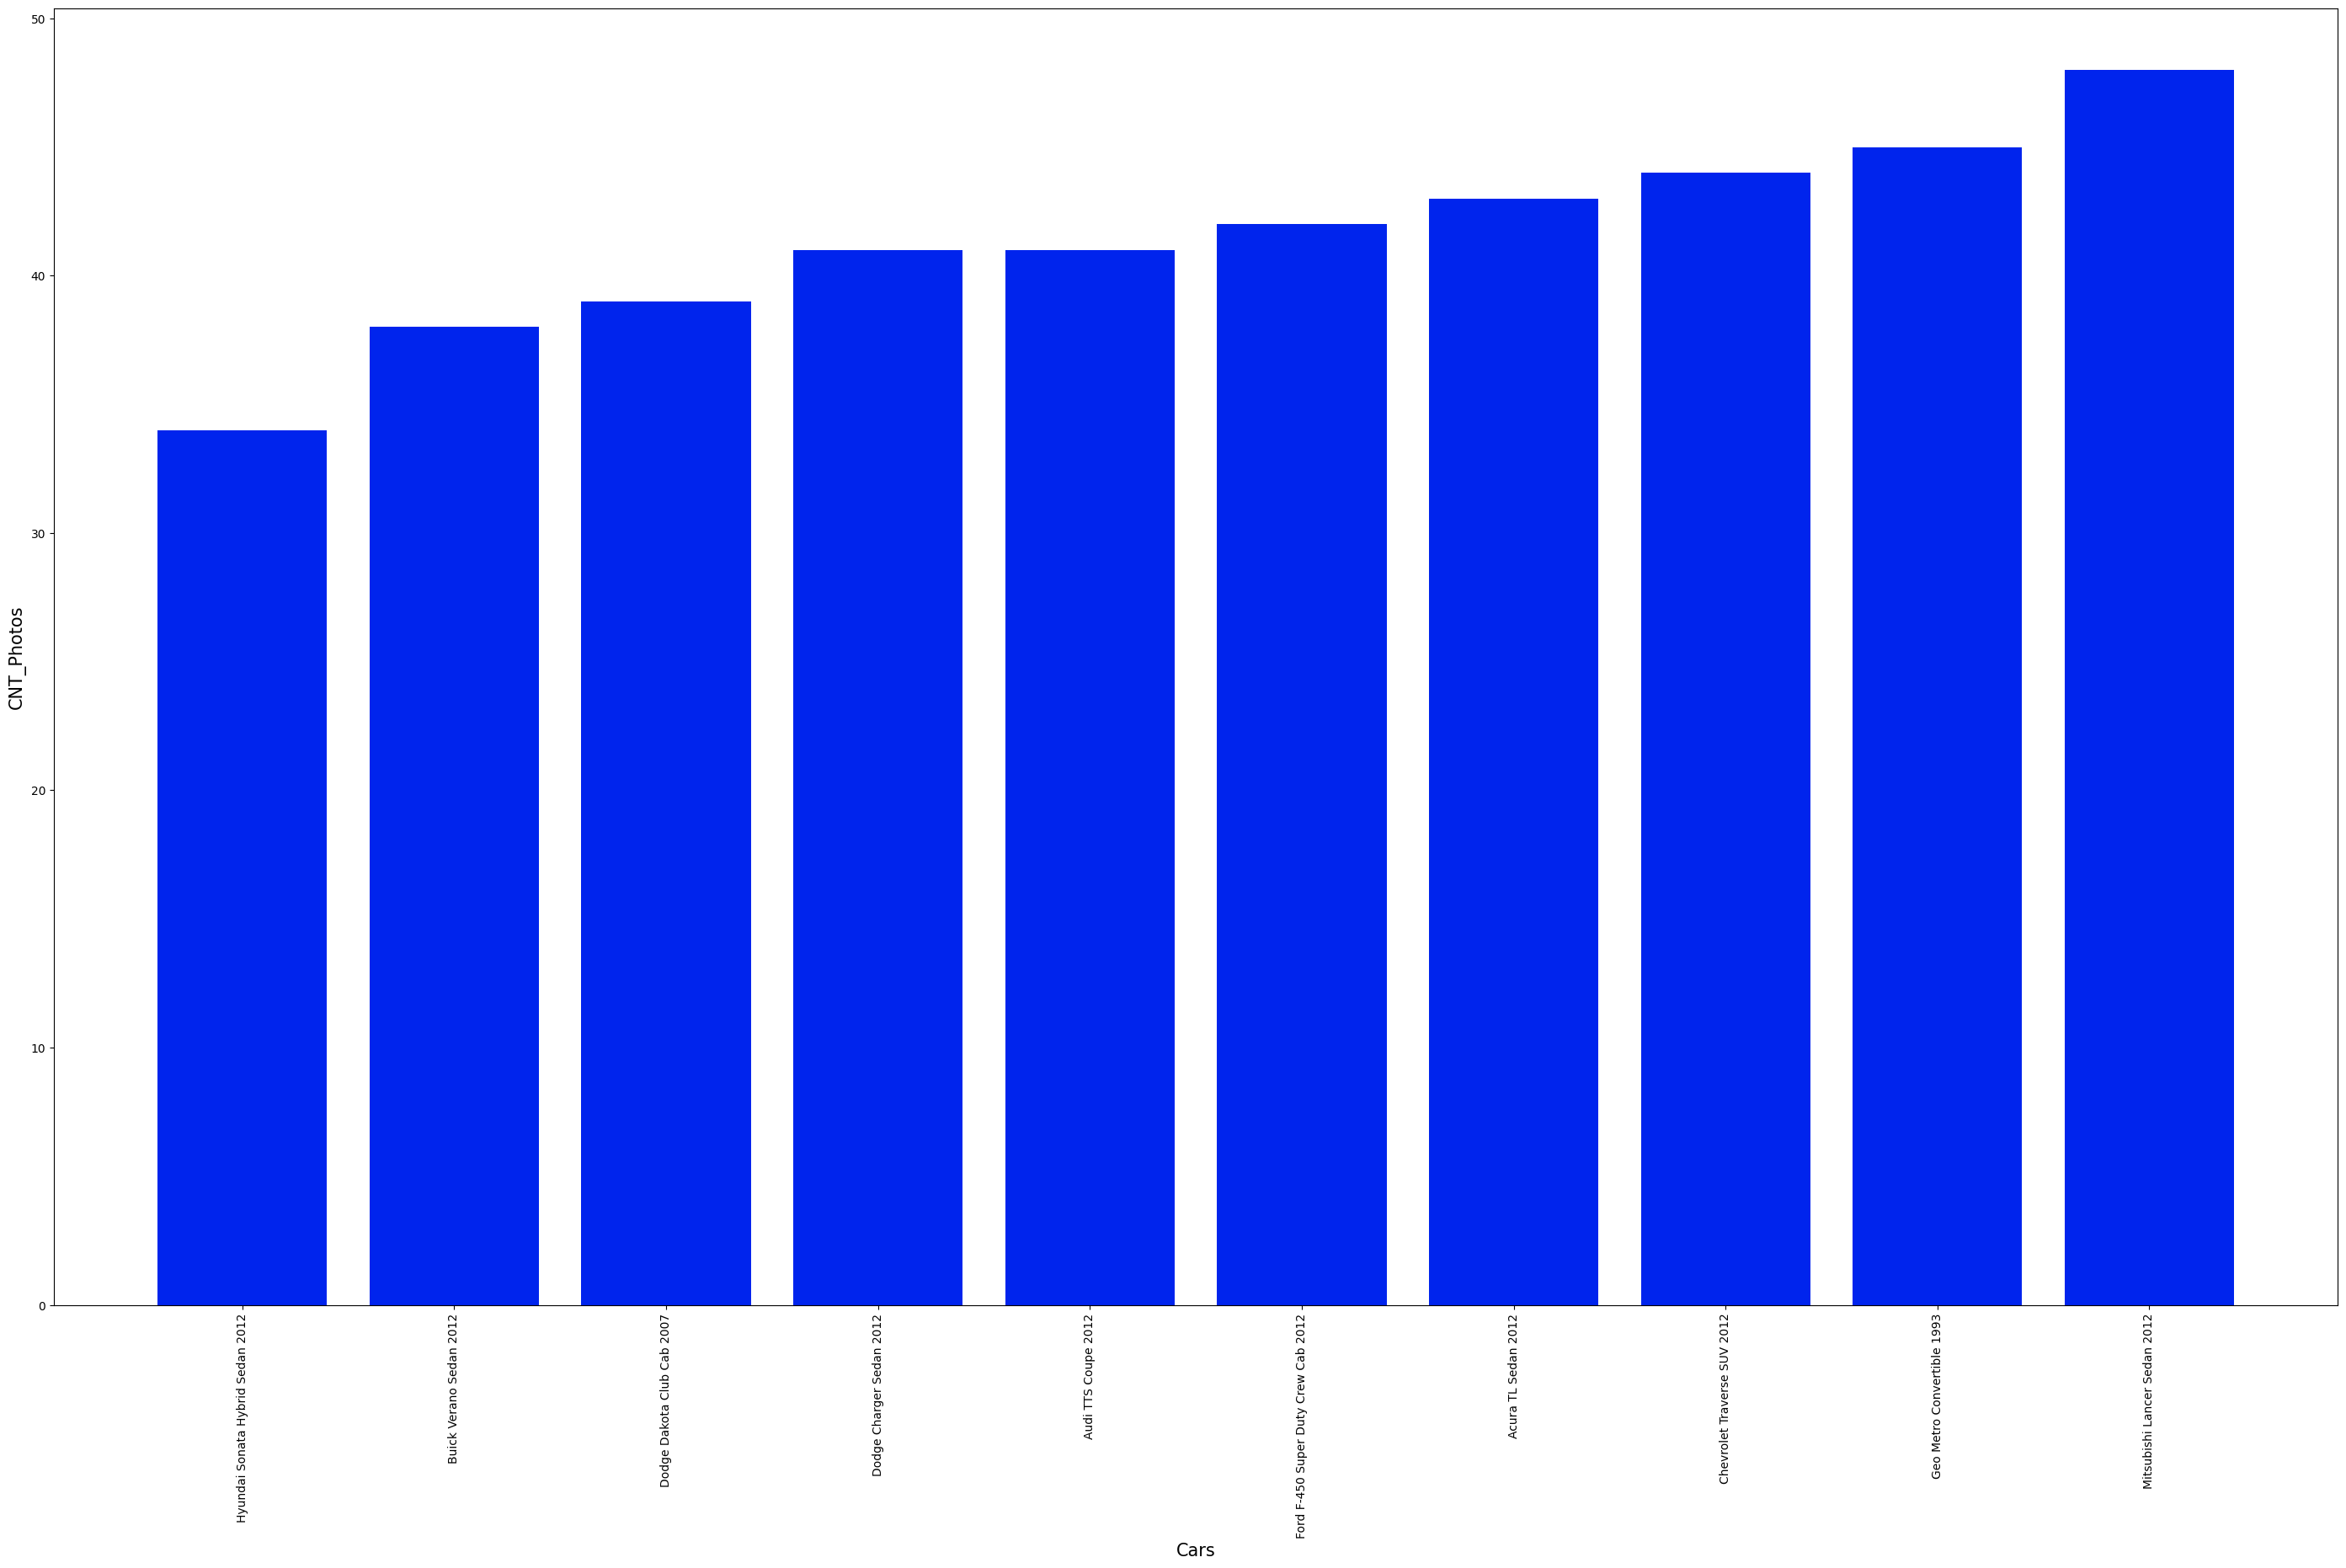

In [8]:
# Визуализация классов
plt.figure(figsize=(35,20))
plt.bar('Cars', 'CNT',data=df_cls_sort)
plt.xticks(rotation=90)
plt.xlabel("Cars", size=15)
plt.ylabel("CNT_Photos", size=15)
plt.show()

In [9]:
def draw_images(image_file):
    image_file_split = image_file.split(".")
    img = cv2.imread(
        image_dir_tr + image_file_split[0] + '.' + image_file_split[1]  + '.' +  image_file_split[2] + ".jpg"
    )

    infile_xml = open(input_dir_tr + image_file)
    tree = ET.parse(infile_xml)
    root = tree.getroot()

    for obj in root.iter("object"):
        cls_name = obj.find("name").text
        xmlbox = obj.find("bndbox")

        xmin = int(float(xmlbox.find("xmin").text))
        xmax = int(float(xmlbox.find("xmax").text))
        ymin = int(float(xmlbox.find("ymin").text))
        ymax = int(float(xmlbox.find("ymax").text))

        font = cv2.FONT_HERSHEY_SIMPLEX

        # put text
        cv2.putText(
            img, cls_name, (xmin, ymin - 10), font, 1, (0, 255, 0), 2, cv2.LINE_AA
        )

        # draw bounding box
        cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0, 255, 0), 3)
    return img

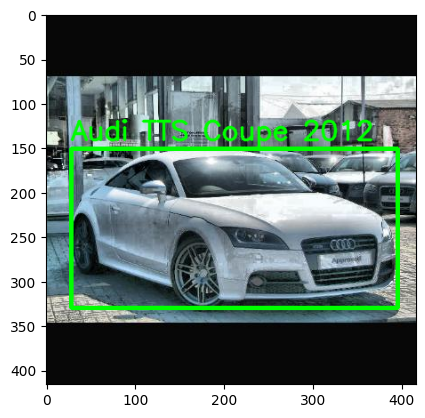

In [10]:
# Пример разметки авто - 1.
img = draw_images("00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41.xml")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

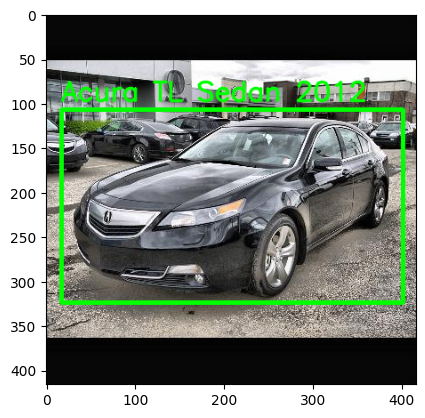

In [11]:
# Пример разметки авто - 2.
img = draw_images("00002_jpg.rf.06ac95f475c437aaf9e3b9e0a4e83995.xml")
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))

#### Конвертация файлов разметки из 'PASCAL VOC format' (XML) в 'YOLO format' (TXT, center-sized coordinates)

In [12]:
def xml_to_yolo_bbox(bbox, w, h):
    # xmin, ymin, xmax, ymax
    x_center = ((bbox[2] + bbox[0]) / 2) / w
    y_center = ((bbox[3] + bbox[1]) / 2) / h
    width = (bbox[2] - bbox[0]) / w
    height = (bbox[3] - bbox[1]) / h
    return [x_center, y_center, width, height]


def yolo_to_xml_bbox(bbox, w, h):
    # x_center, y_center width heigth
    w_half_len = (bbox[2] * w) / 2
    h_half_len = (bbox[3] * h) / 2
    xmin = int((bbox[0] * w) - w_half_len)
    ymin = int((bbox[1] * h) - h_half_len)
    xmax = int((bbox[0] * w) + w_half_len)
    ymax = int((bbox[1] * h) + h_half_len)
    return [xmin, ymin, xmax, ymax]

In [13]:
# classes = []

In [14]:
# try:
#     os.mkdir(output_dir_tr)
# except FileExistsError:
#     next

In [15]:
# # identify all the xml files in the annotations folder (input directory)
# files = glob.glob(os.path.join(input_dir_tr, "*.xml"))
# # loop through each
# for fil in files:
#     basename = os.path.basename(fil)
#     filename = os.path.splitext(basename)[0]
#     # check if the label contains the corresponding image file
#     if not os.path.exists(os.path.join(image_dir_tr, f"{filename}.jpg")):
#         print(f"{filename} image does not exist!")
#         continue

#     result = []

#     # parse the content of the xml file
#     tree = ET.parse(fil)
#     root = tree.getroot()
#     width = int(root.find("size").find("width").text)
#     height = int(root.find("size").find("height").text)

#     for obj in root.findall("object"):
#         label = obj.find("name").text
#         # check for new classes and append to list
#         if label not in classes:
#             classes.append(label)
#         index = classes.index(label)
#         # pil_bbox = [int(x.text) for x in obj.find("bndbox")]
#         pil_bbox = [int(float(x.text)) for x in obj.find("bndbox")]
#         yolo_bbox = xml_to_yolo_bbox(pil_bbox, width, height)
#         # convert data to string
#         bbox_string = " ".join([str(x) for x in yolo_bbox])
#         result.append(f"{index} {bbox_string}")

#     if result:
#         # generate a YOLO format text file for each xml file
#         with open(
#             os.path.join(output_dir_tr, f"{filename}.txt"), "w", encoding="utf-8"
#         ) as f:
#             f.write("\n".join(result))

In [16]:
# generate the classes file as reference
# Беерем ограниченный список классов - 10 

# with open(
#     bp_train_10_car_model + "classes_cars_10.txt",
#     "w",
#     encoding="utf8",
# ) as f:
#     f.write(json.dumps(classes))

In [17]:
# dataset = importer.ImportVOC(path=input_dir_tr)
# dataset.export.ExportToYoloV5(output_path=output_dir_tr)
# dataset = importer.ImportVOC(path=input_dir_val)
# dataset.export.ExportToYoloV5(output_path=output_dir_val)

In [18]:
os.chdir(bp_train_10_car_model)

In [19]:
# try:
#     os.rename('dataset.yaml', 'dataset_cars_10.yaml')
# except FileExistsError:
#     os.remove('dataset_cars_10.yaml')
#     os.rename('dataset.yaml', 'dataset_cars_10.yaml')

In [20]:
def draw_image(img, bboxes):
    draw = ImageDraw.Draw(img)
    
    for bbox in bboxes:
        draw.rectangle(bbox, outline=(0, 255, 0), width=3)
    img.show()
    img.save("example.jpg")

In [21]:
image_filename = image_dir_tr + "00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41.jpg"
label_filename = output_dir_tr + "00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41.txt"
bboxes = []

In [22]:
img = Image.open(image_filename)
with open(label_filename, "r", encoding="utf8") as f:
    for line in f:
        data = line.strip().split(" ")
        bbox = [float(x) for x in data[1:]]
        bboxes.append(yolo_to_xml_bbox(bbox, img.width, img.height))

In [23]:
draw_image(img, bboxes)

### 2. Методика реализации
### 2.1. YOLOv8
#### Клонируем репозиторию Ultralytics c pretrained-моделью YOLOv8 с целью дальнейшего обучения модели на нашем датасете.

In [24]:
os.chdir(base_path_10_car_model)

In [25]:
model_yolo_s = YOLO('yolov8s.yaml').load('yolov8s.pt') 
# model_yolo_n = YOLO('yolov8n.yaml').load('yolov8n.pt') 
# model_yolo_l = YOLO('yolov8l.yaml').load('yolov8l.pt') 

Transferred 355/355 items from pretrained weights


In [26]:
img = image_dir_tr + "00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41.jpg"

#### Проверка pretrained-модели на снимке из нашего датасета, чтобы убедиться в корректности работы (предобучена на датасете MS COCO) 

In [27]:
# Всё работает
results_model_s = model_yolo_s(img)


image 1/1 G:\Code\Netology\Python\DS\\Dataset\data_car_model_10_detection.voc\train\images\00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41.jpg: 640x640 6 2s, 4.0ms
Speed: 3.0ms preprocess, 4.0ms inference, 39.0ms postprocess per image at shape (1, 3, 640, 640)


In [28]:
def visual_detection(results_model):
    for result in results_model:
        boxes = result.boxes  # Boxes object for bounding box outputs
        masks = result.masks  # Masks object for segmentation masks outputs
        keypoints = result.keypoints  # Keypoints object for pose outputs
        probs = result.probs  # Probs object for classification outputs
        result.show()

In [29]:
visual_detection(results_model_s)

#### Переобучение модели YOLOv8 на новом сокращенном датасете (10 марок и модей от общего датасета). Для контроля обучения используем Tensorboard

In [30]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [31]:
os.chdir(core_dir)

In [32]:
# Train YOLOv8s on CoCo128 for 3 epochs
model_yolo_s.train(data='coco128.yaml', epochs=3, batch=16, device=device)

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=coco128.yaml, epochs=3, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, s

train: Scanning G:\Code\Netology\Python\DS\Диплом\Notebook\datasets\coco128\labels\train2017.cache... 126 images, 2 bac
val: Scanning G:\Code\Netology\Python\DS\Диплом\Notebook\datasets\coco128\labels\train2017.cache... 126 images, 2 backg


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train6
Starting training for 3 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/3      4.95G      2.919      4.531       2.43        217        640: 100%|██████████| 8/8 [00:02<00:00,  3.84
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<0

                   all        128        929     0.0991    0.00128    0.00024   6.27e-05



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        2/3      4.54G      2.902      4.509      2.378        218        640: 100%|██████████| 8/8 [00:01<00:00,  6.26
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        128        929     0.0846    0.00477   0.000525   0.000188



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        3/3      4.75G      2.863      4.363      2.393        215        640: 100%|██████████| 8/8 [00:01<00:00,  7.25
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:00<0

                   all        128        929    0.00127     0.0128    0.00281    0.00142



3 epochs completed in 0.004 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 22.6MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 22.6MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLOv8s summary (fused): 168 layers, 11156544 parameters, 0 gradients, 28.6 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:01<0


                   all        128        929    0.00126     0.0128     0.0028    0.00142
                person        128        254    0.00309      0.461     0.0571     0.0218
               bicycle        128          6          0          0          0          0
                   car        128         46          0          0          0          0
            motorcycle        128          5          0          0          0          0
              airplane        128          6          0          0          0          0
                   bus        128          7          0          0          0          0
                 train        128          3          0          0          0          0
                 truck        128         12          0          0          0          0
                  boat        128          6          0          0          0          0
         traffic light        128         14          0          0          0          0
             stop sig

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 11, 13, 14, 15, 16, 17, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 38, 39, 40, 41, 42, 43, 44, 45, 46, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 67, 68, 69, 71, 72, 73, 74, 75, 76, 77, 79])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x0000017240F3DED0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027

#### Ограничение дата сета

In [33]:
# os.chdir(base_path_10_car_model)

In [34]:
# files_annot = os.listdir(input_dir_val)
# files_annot.remove('.DS_Store')
# files_name = []
# for img_name in files_annot:
#     image_file_split = img_name.split(".")
#     img_af_spl = image_file_split[0] + '.' + image_file_split[1]  + '.' +  image_file_split[2] + '.jpg'
#     files_name.append(img_af_spl)

In [35]:
# files_img = os.listdir(image_dir_val)
# list_for_del = []
# i = 0
# for img_delete in files_img:
#     if img_delete not in files_name:
#         list_for_del.append(img_delete)

In [36]:
# len(list_for_del)

In [37]:
# for ing_del in list_for_del:
#     os.remove(image_dir_val + ing_del)

#### Обучение модели новым классам

In [38]:
os.chdir(bp_train_10_car_model)

In [39]:
model_yolo_s.train(data=bp_train_10_car_model + 'dataset_cars_10.yaml', epochs=100, batch=16, workers=32, imgsz=416, device=device, save=True, resume=True)

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
engine\trainer: task=detect, mode=train, model=yolov8s.yaml, data=G:/Code/Netology/Python/DS//Dataset/data_car_model_10_detection.voc/train/dataset_cars_10.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=416, save=True, save_period=-1, cache=False, device=cuda, workers=32, project=None, name=train6, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=None, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, s

train: Scanning G:\Code\Netology\Python\DS\Диплом\Dataset\data_car_model_10_detection.voc\train\labels.cache... 336 ima
val: Scanning G:\Code\Netology\Python\DS\Диплом\Dataset\data_car_model_10_detection.voc\train\labels.cache... 336 image


Plotting labels to runs\detect\train6\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000714, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 416 train, 416 val
Using 32 dataloader workers
Logging results to runs\detect\train6
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.08G      2.189      3.937      2.117         43        416: 100%|██████████| 21/21 [00:02<00:00,  7.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.746     0.0684      0.111     0.0778



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.06G      1.229      3.397      1.544         36        416: 100%|██████████| 21/21 [00:01<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.757     0.0849      0.162     0.0942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.06G     0.9406      2.848      1.362         42        416: 100%|██████████| 21/21 [00:01<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.223      0.656      0.266      0.229



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.04G     0.8228      2.425      1.278         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.324      0.525      0.389      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.04G       0.79      2.117      1.234         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.239      0.743      0.436      0.382



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.04G     0.7619      1.986      1.194         34        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.418      0.717      0.559      0.497



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.04G     0.7183      1.846      1.181         34        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.485      0.645      0.563      0.503



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.03G     0.6947      1.758      1.173         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.579      0.675      0.723      0.651



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.04G     0.6733      1.651      1.159         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.602      0.776      0.757      0.684



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.04G     0.6578       1.48      1.126         31        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.656       0.71       0.74      0.683



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.04G     0.6186      1.442      1.106         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.758      0.674      0.811      0.733



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.04G     0.6434      1.379      1.116         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.792      0.846      0.921      0.849



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.04G     0.6366      1.336      1.112         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.872      0.889      0.942      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.03G     0.6218      1.232      1.101         30        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.803       0.91       0.96      0.892



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.04G     0.5985       1.21      1.083         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.892      0.925      0.975      0.909



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.04G     0.5761      1.104      1.072         50        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.897      0.908      0.973      0.906



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.04G     0.5984      1.094      1.074         45        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.958      0.926      0.986      0.919



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.04G     0.5979      1.053      1.086         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336       0.91      0.857      0.971      0.885



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.04G     0.5769      1.042      1.089         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.974       0.94       0.99      0.929



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.04G     0.5498     0.9563       1.07         44        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.892      0.926      0.981      0.922



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.04G     0.5686     0.9522      1.078         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.974      0.984      0.994      0.934



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.05G     0.5531     0.9198      1.056         41        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.943      0.967      0.993      0.936



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.04G     0.5528     0.8979      1.055         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.956      0.969      0.994      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.04G     0.5536     0.9399      1.053         45        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.984      0.976      0.995      0.939



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.04G      0.532     0.8789      1.045         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.982      0.974      0.994      0.935



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.03G     0.5349     0.9139      1.044         44        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.956       0.97      0.993       0.94



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.04G      0.512     0.8559      1.036         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.965      0.971      0.991      0.943



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.04G     0.5235     0.8281      1.037         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.951      0.955      0.987      0.933



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.04G     0.5025      0.788      1.023         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336       0.99      0.985      0.995      0.945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.04G     0.5083     0.7503      1.023         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.975      0.972      0.993      0.942



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.04G     0.5152     0.7936      1.028         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.987      0.987      0.994      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.04G     0.5166     0.7623      1.035         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.979      0.995      0.995      0.949



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.04G     0.5351     0.7635      1.038         40        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.993       0.99      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.05G     0.5192     0.7714      1.032         35        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.989       0.99      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.04G     0.5037     0.7001      1.018         32        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.993      0.992      0.995      0.948



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.04G     0.5056     0.6849       1.03         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.995      0.996      0.995      0.946



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.04G     0.4707     0.6734      1.008         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.984      0.993      0.995      0.947



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.03G     0.4787     0.6937      1.008         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.989      0.998      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.04G     0.4913     0.7201      1.012         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.992      0.994      0.995      0.944



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.04G     0.4798     0.6481      1.016         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.984          1      0.995      0.954



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.04G     0.4741     0.6597     0.9989         34        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.975      0.992      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.04G     0.5043     0.6843      1.022         44        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.991      0.998      0.995      0.957



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.04G     0.4824     0.6535      1.004         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.989      0.992      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.04G     0.4819     0.6605      1.024         44        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.958



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.04G     0.4817     0.6281      1.012         42        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.993      0.998      0.995      0.953



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.05G     0.4432     0.6071     0.9917         30        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.992      0.996      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.04G     0.4859     0.6067     0.9992         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.992      0.996      0.995      0.959



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.04G     0.4684     0.6176      1.001         46        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.04G     0.4646     0.5865      0.998         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.999      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.03G     0.4595     0.5964     0.9952         40        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997      0.996      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.04G     0.4453     0.6047      1.001         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997      0.998      0.995      0.962



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.04G      0.443     0.5532      0.998         31        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.998      0.995      0.955



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.04G     0.4297     0.5462     0.9809         44        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.993      0.993      0.995       0.96



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.04G       0.45     0.5758     0.9837         30        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336       0.99      0.976      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.04G     0.4393      0.542     0.9799         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.999      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.04G     0.4639     0.5645      1.003         34        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997      0.997      0.995      0.961



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.04G     0.4176       0.53     0.9693         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.05G     0.4537     0.5601      0.995         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998          1      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.04G     0.4393     0.5518     0.9882         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.995          1      0.995      0.968



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.04G     0.4375      0.545     0.9892         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998      0.998      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.04G     0.4488     0.5265     0.9981         46        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.995      0.998      0.995      0.969



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.03G     0.4337     0.5343     0.9787         42        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.994      0.999      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.04G     0.4383     0.5018     0.9884         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.994      0.986      0.995      0.964



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.04G     0.4134     0.4843     0.9655         41        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.967



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.04G     0.4396     0.5157     0.9814         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.04G     0.4248     0.5021     0.9815         35        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.04G       0.43     0.5044     0.9815         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998          1      0.995       0.97



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.04G     0.4206     0.4719     0.9792         34        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.972



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.04G     0.4419      0.512     0.9898         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.971



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.05G      0.401     0.4805      0.973         38        416: 100%|██████████| 21/21 [00:01<00:00, 10.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997      0.999      0.995      0.973



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.04G     0.4082     0.4789     0.9742         39        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.999      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.04G     0.4013     0.4663     0.9775         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.04G     0.4012     0.4681     0.9683         46        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.03G     0.4018     0.4821     0.9655         41        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.04G     0.3965     0.4772     0.9747         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.999      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.04G     0.4045     0.4782     0.9697         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.04G     0.3885     0.4519     0.9583         47        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.974



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.04G     0.3837     0.4518     0.9583         35        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.04G     0.3902     0.4524     0.9562         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.04G     0.3983     0.4358     0.9792         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.04G     0.3977     0.4531     0.9725         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.976



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.05G     0.4138     0.4407     0.9738         35        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.977



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.04G     0.3867     0.4219     0.9713         36        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.979



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.04G        0.4     0.4522     0.9737         38        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996      0.999      0.995      0.975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.04G     0.3947     0.4293      0.971         30        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.995          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.03G     0.3993     0.4359     0.9759         37        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.978



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.04G     0.3726     0.4239     0.9563         33        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.04G     0.3654     0.4049     0.9554         40        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.04G     0.3796     0.4022     0.9652         43        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.04G     0.3795     0.4136     0.9663         42        416: 100%|██████████| 21/21 [00:01<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.981


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.04G     0.2676      0.322     0.8705         16        416: 100%|██████████| 21/21 [00:02<00:00,  9.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995       0.98



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.04G     0.2444     0.2979     0.8655         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.04G     0.2362     0.2887     0.8584         16        416: 100%|██████████| 21/21 [00:01<00:00, 12.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998          1      0.995      0.981



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.05G     0.2416     0.2779     0.8573         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.998          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.04G     0.2307     0.2803     0.8594         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.04G     0.2315     0.2795     0.8523         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.04G     0.2257     0.2723     0.8559         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.996          1      0.995      0.983



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.03G     0.2256     0.2637      0.856         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.04G     0.2331     0.2678     0.8456         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.984



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.04G     0.2302     0.2647     0.8564         16        416: 100%|██████████| 21/21 [00:01<00:00, 11.
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:01

                   all        336        336      0.997          1      0.995      0.985



100 epochs completed in 0.142 hours.
Optimizer stripped from runs\detect\train6\weights\last.pt, 22.5MB
Optimizer stripped from runs\detect\train6\weights\best.pt, 22.5MB

Validating runs\detect\train6\weights\best.pt...
Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLOv8s summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 11/11 [00:02


                   all        336        336      0.997          1      0.995      0.984
   Audi TTS Coupe 2012        336         35      0.997          1      0.995      0.987
   Acura TL Sedan 2012        336         29      0.999          1      0.995       0.97
Dodge Dakota Club Cab 2007        336         33      0.996          1      0.995      0.987
Hyundai Sonata Hybrid Sedan 2012        336         31      0.997          1      0.995      0.995
Ford F-450 Super Duty Crew Cab 2012        336         39      0.997          1      0.995      0.988
Geo Metro Convertible 1993        336         36      0.997          1      0.995      0.975
Dodge Charger Sedan 2012        336         33      0.997          1      0.995      0.989
Mitsubishi Lancer Sedan 2012        336         35      0.999          1      0.995      0.987
Chevrolet Traverse SUV 2012        336         36      0.999          1      0.995      0.969
Buick Verano Sedan 2012        336         29      0.997          

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001726CC25150>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [40]:
model_yolo_s_train = YOLO('runs/detect/train6/weights/best.pt')
model_yolo_s_train.val()

Ultralytics YOLOv8.1.47  Python-3.11.7 torch-2.2.2+cu118 CUDA:0 (NVIDIA GeForce RTX 4070 Ti, 12282MiB)
YOLOv8s summary (fused): 168 layers, 11129454 parameters, 0 gradients, 28.5 GFLOPs


val: Scanning G:\Code\Netology\Python\DS\Диплом\Dataset\data_car_model_10_detection.voc\train\labels.cache... 336 image
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 21/21 [00:03


                   all        336        336      0.997          1      0.995      0.984
   Audi TTS Coupe 2012        336         35      0.997          1      0.995      0.987
   Acura TL Sedan 2012        336         29      0.999          1      0.995       0.97
Dodge Dakota Club Cab 2007        336         33      0.996          1      0.995      0.987
Hyundai Sonata Hybrid Sedan 2012        336         31      0.997          1      0.995      0.995
Ford F-450 Super Duty Crew Cab 2012        336         39      0.997          1      0.995      0.988
Geo Metro Convertible 1993        336         36      0.997          1      0.995      0.975
Dodge Charger Sedan 2012        336         33      0.997          1      0.995      0.989
Mitsubishi Lancer Sedan 2012        336         35      0.999          1      0.995      0.983
Chevrolet Traverse SUV 2012        336         36      0.999          1      0.995      0.972
Buick Verano Sedan 2012        336         29      0.997          

ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x000001726CB25ED0>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,   

In [252]:
val_img = image_dir_val + '03804_jpg.rf.9080d44093c44079f127734e8cde2093.jpg'
result_1_after_train_s = model_yolo_s_train(val_img)
visual_detection(result_1_after_train_s)


image 1/1 G:\Code\Netology\Python\DS\\Dataset\data_car_model_10_detection.voc\valid\images\03804_jpg.rf.9080d44093c44079f127734e8cde2093.jpg: 416x416 1 Audi TTS Coupe 2012, 92.0ms
Speed: 2.0ms preprocess, 92.0ms inference, 2.0ms postprocess per image at shape (1, 3, 416, 416)


In [253]:
val_img = image_dir_val + '00875_jpg.rf.3813bffa871fe29533319414d89f8a8f.jpg'
result_1_after_train_s = model_yolo_s_train(val_img)
visual_detection(result_1_after_train_s)


image 1/1 G:\Code\Netology\Python\DS\\Dataset\data_car_model_10_detection.voc\valid\images\00875_jpg.rf.3813bffa871fe29533319414d89f8a8f.jpg: 416x416 1 Dodge Charger Sedan 2012, 85.0ms
Speed: 2.0ms preprocess, 85.0ms inference, 4.0ms postprocess per image at shape (1, 3, 416, 416)


In [42]:
os.chdir(core_dir)

In [43]:
model_yolo_s_train

YOLO(
  (model): DetectionModel(
    (model): Sequential(
      (0): Conv(
        (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (1): Conv(
        (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        (act): SiLU(inplace=True)
      )
      (2): C2f(
        (cv1): Conv(
          (conv): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (cv2): Conv(
          (conv): Conv2d(96, 64, kernel_size=(1, 1), stride=(1, 1))
          (act): SiLU(inplace=True)
        )
        (m): ModuleList(
          (0): Bottleneck(
            (cv1): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
            )
            (cv2): Conv(
              (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
              (act): SiLU(inplace=True)
   

In [44]:
# Start tensorboard
%load_ext tensorboard

In [45]:
%reload_ext tensorboard

In [46]:
%tensorboard --inspect --logdir core_dir + '/runs/detect/train42' --bind_all

ERROR: Could not find `tensorboard`. Please ensure that your PATH
contains an executable `tensorboard` program, or explicitly specify
the path to a TensorBoard binary by setting the `TENSORBOARD_BINARY`
environment variable.

In [47]:
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

### 2.2. SSD300@VGG16.

#### Предобработаем данные [загрузка, разметка, аугментация, разделение на трейн- и тест-выборки, функции расчета метрик (mean Average Precision, Accuracy) и т.д.]

##### Подготовка структуры для модели

In [184]:
os.chdir(base_path_SSD300_10_car_model)

In [185]:
# os.chdir(core_dir)
# try:
#     os.mkdir('for_SSD300')
# except FileExistsError:
#     next

In [186]:
# os.chdir(base_path_SSD300_10_car_model)
# try:
#     os.mkdir('JPEGImages')
# except FileExistsError:
#     next

# try:
#     os.mkdir('ImageSets')
# except FileExistsError:
#     next
    
# try:
#     os.mkdir('Annotations')
# except FileExistsError:
#     next

In [187]:
# os.chdir(SSD300_imgset)

# try:
#     os.mkdir('Main')
# except FileExistsError:
#     next

In [188]:
# os.chdir(SSD300_imgset + "/Main")
# df_trainval = pd.read_csv('trainval.txt', delimiter='\t', names=['name_files'])

In [189]:
# df_val = df_trainval.sample(frac=0.2)
# df_val.to_csv('val.txt', sep = '\t', index = False)

In [190]:
# df_test = df_trainval.merge(df_val, how='outer')
# df_test = df_test.sample(frac=0.2)
# df_test.to_csv('test.txt', sep = '\t', index = False)

In [191]:
# df_trainval = df_trainval[~df_trainval.isin(df_test)].dropna()
# df_trainval.to_csv('trainval.txt', sep = '\t', index = False)

In [192]:
# df_train = df_trainval[~df_trainval.isin(df_val)].dropna()
# df_trainval.to_csv('train.txt', sep = '\t', index = False)

In [193]:
def create_data_lists(dataset_path, output_folder):
    """
    Create lists of images, the bounding boxes and labels of the objects in these images, and save these to file.

    :param dataset_path: path to the dataset folder
    :param output_folder: folder where the JSONs must be saved
    """
    dataset_path = os.path.abspath(dataset_path)

    train_images = list()
    train_objects = list()
    n_objects = 0

    # Training data
    for path in [dataset_path]:
        # Find IDs of images in training data
        with open(os.path.join(path, "ImageSets/Main/trainval.txt")) as f:
            ids = f.read().splitlines()

        for id in ids:
            # Parse annotation's XML file
            objects = parse_annotation(os.path.join(path, "Annotations", id + ".xml"))
            #             print(len(objects), objects, objects['boxes'])
            if (len(objects) == 0) or (objects["boxes"] == []):
                continue
            n_objects += len(objects)
            train_objects.append(objects)
            train_images.append(os.path.join(path, "JPEGImages", id + ".jpg"))

    assert len(train_objects) == len(train_images)

    # Save to file
    with open(os.path.join(output_folder, "TRAIN_images.json"), "w") as j:
        json.dump(train_images, j)
    with open(os.path.join(output_folder, "TRAIN_objects.json"), "w") as j:
        json.dump(train_objects, j)
    with open(os.path.join(output_folder, "label_map.json"), "w") as j:
        json.dump(label_map, j)  # save label map too

    print(
        "\nThere are %d training images containing a total of %d objects. Files have been saved to %s."
        % (len(train_images), n_objects, os.path.abspath(output_folder))
    )

    # Test data
    test_images = list()
    test_objects = list()
    n_objects = 0

    # Find IDs of images in the test data
    with open(os.path.join(dataset_path, "ImageSets/Main/test.txt")) as f:
        ids = f.read().splitlines()

    for id in ids:
        # Parse annotation's XML file
        objects = parse_annotation(
            os.path.join(dataset_path, "Annotations", id + ".xml")
        )
        #         print(len(objects), objects, objects['boxes'])
        if (len(objects) == 0) or (objects["boxes"] == []):
            continue
        test_objects.append(objects)
        n_objects += len(objects)
        test_images.append(os.path.join(dataset_path, "JPEGImages", id + ".jpg"))

    assert len(test_objects) == len(test_images)

    # Save to file
    with open(os.path.join(output_folder, "TEST_images.json"), "w") as j:
        json.dump(test_images, j)
    with open(os.path.join(output_folder, "TEST_objects.json"), "w") as j:
        json.dump(test_objects, j)

    print(
        "\nThere are %d test images containing a total of %d objects. Files have been saved to %s."
        % (len(test_images), n_objects, os.path.abspath(output_folder))
    )

In [194]:
# # перечень наименований файлов в VAL-выборке (для формирования файла \ImageSets\Main\val.txt)
# os.chdir('D:\\Netology\\Diplom\\Road Damage Detection\\CRDDC_2022\\Dataset\\All\\val_dest_formatCOCOjson')
# for root, dirs, files in os.walk(".", topdown = True):
#     for name in files:
#         if name.endswith('.jpg'):
#             print(name.split(".")[0])
#     for name in dirs:
#         if name.endswith('.jpg'):
#             print(name.split(".")[0])

In [195]:
# # перечень наименований файлов в TRAIN-выборке (для формирования файла \ImageSets\Main\train.txt)
# os.chdir('D:\\Netology\\Diplom\\Road Damage Detection\\CRDDC_2022\\Dataset\\All\\train_dest_formatCOCOjson')
# for root, dirs, files in os.walk(".", topdown = True):
#     for name in files:
#         if name.endswith('.jpg'):
#             print(name.split(".")[0])
#     for name in dirs:
#         if name.endswith('.jpg'):
#             print(name.split(".")[0])

In [196]:
# перечень наименований файлов в TEST-выборке (для формирования файла \ImageSets\Main\test.txt)
os.chdir(SSD300_jpg_img)
for root, dirs, files in os.walk(".", topdown=True):
    for name in files:
        if name.endswith(".jpg"):
            print(name.split(".")[0] + '.' + name.split(".")[1] + '.' + name.split(".")[2])
    for name in dirs:
        if name.endswith(".jpg"):
            print(name.split(".")[0] + '.' + name.split(".")[1] + '.' + name.split(".")[2])

00001_jpg.rf.a2fb7c8a74d3c1652d2914fff3013e41
00002_jpg.rf.06ac95f475c437aaf9e3b9e0a4e83995
00003_jpg.rf.12f7efcbaf7b0e49df9730caaee211e5
00004_jpg.rf.c7786b3791ef1132d12fa0f33e1df6e9
00005_jpg.rf.47130cdc6a033ef00309753ef6fec81f
00006_jpg.rf.304d2ef0c301111639d889890a6a6a57
00008_jpg.rf.b949ba93ea5f1381eee2bf8f2fe17155
00009_jpg.rf.80a696598fb0a8d25f13f6128f73a51c
00010_jpg.rf.8ec3ee4353bf2d311846cf33227bd351
00011_jpg.rf.680407b8692573ec57276118b64ea346
00017_jpg.rf.473dd90a92ddc3615f2f3bcc53d29a50
00026_jpg.rf.70e0351a92f40258a1a293f30670565f
00051_jpg.rf.af934c151ff96ac3a792a556e5a1c7f3
00073_jpg.rf.2a3ea36aa94963867191306fc213fd28
00074_jpg.rf.36bae2f21e334014c7967e6a37fc2531
00085_jpg.rf.5a75b55cd4339e4af86a6c2203d54a2a
00087_jpg.rf.7ad40f697f257f8f30d6f69ed4dba113
00135_jpg.rf.a210ec3f88615abb65fe416035e8619f
00231_jpg.rf.4a36ec341d57bdccbef055550b005ca5
00246_jpg.rf.e4c169b50e944a73682d655db1655164
00251_jpg.rf.9bf7905f071e2ad147d7de079892db76
00260_jpg.rf.5b3b0a9284677edc8fe15

In [197]:
# Label map
voc_labels = ("Chevrolet Traverse SUV 2012", 
              "Dodge Dakota Club Cab 2007", 
              "Buick Verano Sedan 2012", 
              "Acura TL Sedan 2012", 
              "Audi TTS Coupe 2012", 
              "Mitsubishi Lancer Sedan 2012", 
              "Hyundai Sonata Hybrid Sedan 2012", 
              "Ford F-450 Super Duty Crew Cab 2012", 
              "Geo Metro Convertible 1993", 
              "Dodge Charger Sedan 2012")
label_map = {k: v + 1 for v, k in enumerate(voc_labels)}
label_map["background"] = 0
rev_label_map = {v: k for k, v in label_map.items()}  # Inverse mapping

In [198]:
# Color map for bounding boxes of detected objects from https://sashat.me/2017/01/11/list-of-20-simple-distinct-colors/
distinct_colors = ["#800000", 
                   "#9A6324", 
                   "#808000", 
                   "#e6194B", 
                   "#f58231",
                   "#ffe119", 
                   "#bfef45", 
                   "#42d4f4", 
                   "#f032e6", 
                   "#dcbeff",
                   "#000000"]
label_color_map = {k: distinct_colors[i] for i, k in enumerate(label_map.keys())}

In [199]:
def parse_annotation(annotation_path):
    tree = ET.parse(annotation_path)
    root = tree.getroot()

    boxes = list()
    labels = list()
    difficulties = list()
    for object in root.iter("object"):

        #         difficult = int(object.find('difficult').text == '1')
        difficult = 0

        #         label = object.find('name').text.lower().strip()
        label = object.find("name").text.strip()

        if label not in label_map:
            #             print("This label is not in label_map: ", label)
            continue

        bbox = object.find("bndbox")
        xmin = int(float(bbox.find("xmin").text)) - 1
        ymin = int(float(bbox.find("ymin").text)) - 1
        xmax = int(float(bbox.find("xmax").text)) - 1
        ymax = int(float(bbox.find("ymax").text)) - 1

        boxes.append([xmin, ymin, xmax, ymax])
        labels.append(label_map[label])
        difficulties.append(difficult)

    return {"boxes": boxes, "labels": labels, "difficulties": difficulties}

In [200]:
if __name__ == "__main__":
    create_data_lists(
        dataset_path=base_path_SSD300_10_car_model,
        output_folder=base_path_SSD300_10_car_model
    )


There are 415 training images containing a total of 1245 objects. Files have been saved to G:\Code\Netology\Python\DS\Диплом\Dataset\data_car_model_10_detection.voc\for_SSD300.

There are 83 test images containing a total of 249 objects. Files have been saved to G:\Code\Netology\Python\DS\Диплом\Dataset\data_car_model_10_detection.voc\for_SSD300.


In [201]:
def decimate(tensor, m):
    """
    Decimate a tensor by a factor 'm', i.e. downsample by keeping every 'm'th value.

    This is used when we convert FC layers to equivalent Convolutional layers, BUT of a smaller size.

    :param tensor: tensor to be decimated
    :param m: list of decimation factors for each dimension of the tensor; None if not to be decimated along a dimension
    :return: decimated tensor
    """
    assert tensor.dim() == len(m)
    for d in range(tensor.dim()):
        if m[d] is not None:
            tensor = tensor.index_select(
                dim=d, index=torch.arange(start=0, end=tensor.size(d), step=m[d]).long()
            )

    return tensor

In [202]:
def calculate_mAP(
    det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties
):
    """
    Calculate the Mean Average Precision (mAP) of detected objects.

    See https://medium.com/@jonathan_hui/map-mean-average-precision-for-object-detection-45c121a31173 for an explanation

    :param det_boxes: list of tensors, one tensor for each image containing detected objects' bounding boxes
    :param det_labels: list of tensors, one tensor for each image containing detected objects' labels
    :param det_scores: list of tensors, one tensor for each image containing detected objects' labels' scores
    :param true_boxes: list of tensors, one tensor for each image containing actual objects' bounding boxes
    :param true_labels: list of tensors, one tensor for each image containing actual objects' labels
    :param true_difficulties: list of tensors, one tensor for each image containing actual objects' difficulty (0 or 1)
    :return: list of average precisions for all classes, mean average precision (mAP)
    """
    assert (
        len(det_boxes)
        == len(det_labels)
        == len(det_scores)
        == len(true_boxes)
        == len(true_labels)
        == len(true_difficulties)
    )  # these are all lists of tensors of the same length, i.e. number of images
    n_classes = len(label_map)

    # Store all (true) objects in a single continuous tensor while keeping track of the image it is from
    true_images = list()
    for i in range(len(true_labels)):
        true_images.extend([i] * true_labels[i].size(0))
    true_images = torch.LongTensor(true_images).to(
        device
    )  # (n_objects), n_objects is the total no. of objects across all images
    true_boxes = torch.cat(true_boxes, dim=0)  # (n_objects, 4)
    true_labels = torch.cat(true_labels, dim=0)  # (n_objects)
    true_difficulties = torch.cat(true_difficulties, dim=0)  # (n_objects)

    assert true_images.size(0) == true_boxes.size(0) == true_labels.size(0)

    # Store all detections in a single continuous tensor while keeping track of the image it is from
    det_images = list()
    for i in range(len(det_labels)):
        det_images.extend([i] * det_labels[i].size(0))
    det_images = torch.LongTensor(det_images).to(device)  # (n_detections)
    det_boxes = torch.cat(det_boxes, dim=0)  # (n_detections, 4)
    det_labels = torch.cat(det_labels, dim=0)  # (n_detections)
    det_scores = torch.cat(det_scores, dim=0)  # (n_detections)

    assert (
        det_images.size(0)
        == det_boxes.size(0)
        == det_labels.size(0)
        == det_scores.size(0)
    )

    # Calculate APs for each class (except background)
    average_precisions = torch.zeros(
        (n_classes - 1), dtype=torch.float
    )  # (n_classes - 1)
    for c in range(1, n_classes):
        # Extract only objects with this class
        true_class_images = true_images[true_labels == c]  # (n_class_objects)
        true_class_boxes = true_boxes[true_labels == c]  # (n_class_objects, 4)
        true_class_difficulties = true_difficulties[
            true_labels == c
        ]  # (n_class_objects)
        n_easy_class_objects = (
            (1 - true_class_difficulties).sum().item()
        )  # ignore difficult objects

        # Keep track of which true objects with this class have already been 'detected'
        # So far, none
        true_class_boxes_detected = torch.zeros(
            (true_class_difficulties.size(0)), dtype=torch.uint8
        ).to(
            device
        )  # (n_class_objects)

        # Extract only detections with this class
        det_class_images = det_images[det_labels == c]  # (n_class_detections)
        det_class_boxes = det_boxes[det_labels == c]  # (n_class_detections, 4)
        det_class_scores = det_scores[det_labels == c]  # (n_class_detections)
        n_class_detections = det_class_boxes.size(0)
        if n_class_detections == 0:
            continue

        # Sort detections in decreasing order of confidence/scores
        det_class_scores, sort_ind = torch.sort(
            det_class_scores, dim=0, descending=True
        )  # (n_class_detections)
        det_class_images = det_class_images[sort_ind]  # (n_class_detections)
        det_class_boxes = det_class_boxes[sort_ind]  # (n_class_detections, 4)

        # In the order of decreasing scores, check if true or false positive
        true_positives = torch.zeros((n_class_detections), dtype=torch.float).to(
            device
        )  # (n_class_detections)
        false_positives = torch.zeros((n_class_detections), dtype=torch.float).to(
            device
        )  # (n_class_detections)
        for d in range(n_class_detections):
            this_detection_box = det_class_boxes[d].unsqueeze(0)  # (1, 4)
            this_image = det_class_images[d]  # (), scalar

            # Find objects in the same image with this class, their difficulties, and whether they have been detected before
            object_boxes = true_class_boxes[
                true_class_images == this_image
            ]  # (n_class_objects_in_img)
            object_difficulties = true_class_difficulties[
                true_class_images == this_image
            ]  # (n_class_objects_in_img)
            # If no such object in this image, then the detection is a false positive
            if object_boxes.size(0) == 0:
                false_positives[d] = 1
                continue

            # Find maximum overlap of this detection with objects in this image of this class
            overlaps = find_jaccard_overlap(
                this_detection_box, object_boxes
            )  # (1, n_class_objects_in_img)
            max_overlap, ind = torch.max(overlaps.squeeze(0), dim=0)  # (), () - scalars

            # 'ind' is the index of the object in these image-level tensors 'object_boxes', 'object_difficulties'
            # In the original class-level tensors 'true_class_boxes', etc., 'ind' corresponds to object with index...
            # We need 'original_ind' to update 'true_class_boxes_detected'
            #           # original_ind = torch.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            
            original_ind = torch.cuda.LongTensor(range(true_class_boxes.size(0)))[true_class_images == this_image][ind]
            
            # изменено с 'torch.LongTensor' на 'torch.cuda.LongTensor',иначе в конце процесса оценки на GPU вылетает с ошибкой

            # If the maximum overlap is greater than the threshold of 0.5, it's a match
            if max_overlap.item() > 0.5:
                # If the object it matched with is 'difficult', ignore it
                if object_difficulties[ind] == 0:
                    # If this object has already not been detected, it's a true positive
                    if true_class_boxes_detected[original_ind] == 0:
                        true_positives[d] = 1
                        true_class_boxes_detected[original_ind] = (
                            1  # this object has now been detected/accounted for
                        )
                    # Otherwise, it's a false positive (since this object is already accounted for)
                    else:
                        false_positives[d] = 1
            # Otherwise, the detection occurs in a different location than the actual object, and is a false positive
            else:
                false_positives[d] = 1

        # Compute cumulative precision and recall at each detection in the order of decreasing scores
        cumul_true_positives = torch.cumsum(
            true_positives, dim=0
        )  # (n_class_detections)
        cumul_false_positives = torch.cumsum(
            false_positives, dim=0
        )  # (n_class_detections)
        cumul_precision = cumul_true_positives / (
            cumul_true_positives + cumul_false_positives + 1e-10
        )  # (n_class_detections)
        cumul_recall = (
            cumul_true_positives / n_easy_class_objects
        )  # (n_class_detections)

        # Find the mean of the maximum of the precisions corresponding to recalls above the threshold 't'
        recall_thresholds = torch.arange(start=0, end=1.1, step=0.1).tolist()  # (11)
        precisions = torch.zeros((len(recall_thresholds)), dtype=torch.float).to(
            device
        )  # (11)
        for i, t in enumerate(recall_thresholds):
            recalls_above_t = cumul_recall >= t
            if recalls_above_t.any():
                precisions[i] = cumul_precision[recalls_above_t].max()
            else:
                precisions[i] = 0.0
        average_precisions[c - 1] = precisions.mean()  # c is in [1, n_classes - 1]

    # Calculate Mean Average Precision (mAP)
    mean_average_precision = average_precisions.mean().item()

    # Keep class-wise average precisions in a dictionary
    average_precisions = {
        rev_label_map[c + 1]: v for c, v in enumerate(average_precisions.tolist())
    }

    return average_precisions, mean_average_precision

In [203]:
def xy_to_cxcy(xy):
    """
    Convert bounding boxes from boundary coordinates (x_min, y_min, x_max, y_max) to center-size coordinates (c_x, c_y, w, h).

    :param xy: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat(
        [(xy[:, 2:] + xy[:, :2]) / 2, xy[:, 2:] - xy[:, :2]], 1  # c_x, c_y
    )  # w, h

In [204]:
def cxcy_to_xy(cxcy):
    """
    Convert bounding boxes from center-size coordinates (c_x, c_y, w, h) to boundary coordinates (x_min, y_min, x_max, y_max).

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_boxes, 4)
    :return: bounding boxes in boundary coordinates, a tensor of size (n_boxes, 4)
    """
    return torch.cat(
        [
            cxcy[:, :2] - (cxcy[:, 2:] / 2),  # x_min, y_min
            cxcy[:, :2] + (cxcy[:, 2:] / 2),
        ],
        1,
    )  # x_max, y_max

In [205]:
def cxcy_to_gcxgcy(cxcy, priors_cxcy):
    """
    Encode bounding boxes (that are in center-size form) w.r.t. the corresponding prior boxes (that are in center-size form).

    For the center coordinates, find the offset with respect to the prior box, and scale by the size of the prior box.
    For the size coordinates, scale by the size of the prior box, and convert to the log-space.

    In the model, we are predicting bounding box coordinates in this encoded form.

    :param cxcy: bounding boxes in center-size coordinates, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding must be performed, a tensor of size (n_priors, 4)
    :return: encoded bounding boxes, a tensor of size (n_priors, 4)
    """

    # The 10 and 5 below are referred to as 'variances' in the original Caffe repo, completely empirical
    # They are for some sort of numerical conditioning, for 'scaling the localization gradient'
    # See https://github.com/weiliu89/caffe/issues/155
    return torch.cat(
        [
            (cxcy[:, :2] - priors_cxcy[:, :2])
            / (priors_cxcy[:, 2:] / 10),  # g_c_x, g_c_y
            torch.log(cxcy[:, 2:] / priors_cxcy[:, 2:]) * 5,
        ],
        1,
    )  # g_w, g_h

In [206]:
def gcxgcy_to_cxcy(gcxgcy, priors_cxcy):
    """
    Decode bounding box coordinates predicted by the model, since they are encoded in the form mentioned above.

    They are decoded into center-size coordinates.

    This is the inverse of the function above.

    :param gcxgcy: encoded bounding boxes, i.e. output of the model, a tensor of size (n_priors, 4)
    :param priors_cxcy: prior boxes with respect to which the encoding is defined, a tensor of size (n_priors, 4)
    :return: decoded bounding boxes in center-size form, a tensor of size (n_priors, 4)
    """

    return torch.cat(
        [
            gcxgcy[:, :2] * priors_cxcy[:, 2:] / 10 + priors_cxcy[:, :2],  # c_x, c_y
            torch.exp(gcxgcy[:, 2:] / 5) * priors_cxcy[:, 2:],
        ],
        1,
    )  # w, h

In [207]:
def find_intersection(set_1, set_2):
    """
    Find the intersection of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: intersection of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # PyTorch auto-broadcasts singleton dimensions
    lower_bounds = torch.max(
        set_1[:, :2].unsqueeze(1), set_2[:, :2].unsqueeze(0)
    )  # (n1, n2, 2)
    upper_bounds = torch.min(
        set_1[:, 2:].unsqueeze(1), set_2[:, 2:].unsqueeze(0)
    )  # (n1, n2, 2)
    intersection_dims = torch.clamp(upper_bounds - lower_bounds, min=0)  # (n1, n2, 2)
    return intersection_dims[:, :, 0] * intersection_dims[:, :, 1]  # (n1, n2)

In [208]:
def find_jaccard_overlap(set_1, set_2):
    """
    Find the Jaccard Overlap (IoU) of every box combination between two sets of boxes that are in boundary coordinates.

    :param set_1: set 1, a tensor of dimensions (n1, 4)
    :param set_2: set 2, a tensor of dimensions (n2, 4)
    :return: Jaccard Overlap of each of the boxes in set 1 with respect to each of the boxes in set 2, a tensor of dimensions (n1, n2)
    """

    # Find intersections
    intersection = find_intersection(set_1, set_2)  # (n1, n2)

    # Find areas of each box in both sets
    areas_set_1 = (set_1[:, 2] - set_1[:, 0]) * (set_1[:, 3] - set_1[:, 1])  # (n1)
    areas_set_2 = (set_2[:, 2] - set_2[:, 0]) * (set_2[:, 3] - set_2[:, 1])  # (n2)

    # Find the union
    # PyTorch auto-broadcasts singleton dimensions
    union = (
        areas_set_1.unsqueeze(1) + areas_set_2.unsqueeze(0) - intersection
    )  # (n1, n2)

    return intersection / union  # (n1, n2)

In [209]:
# Some augmentation functions below have been adapted from
# From https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py


def expand(image, boxes, filler):
    """
    Perform a zooming out operation by placing the image in a larger canvas of filler material.

    Helps to learn to detect smaller objects.

    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param filler: RBG values of the filler material, a list like [R, G, B]
    :return: expanded image, updated bounding box coordinates
    """
    # Calculate dimensions of proposed expanded (zoomed-out) image
    original_h = image.size(1)
    original_w = image.size(2)
    max_scale = 4
    scale = random.uniform(1, max_scale)
    new_h = int(scale * original_h)
    new_w = int(scale * original_w)

    # Create such an image with the filler
    filler = torch.FloatTensor(filler)  # (3)
    new_image = torch.ones((3, new_h, new_w), dtype=torch.float) * filler.unsqueeze(
        1
    ).unsqueeze(
        1
    )  # (3, new_h, new_w)
    # Note - do not use expand() like new_image = filler.unsqueeze(1).unsqueeze(1).expand(3, new_h, new_w)
    # because all expanded values will share the same memory, so changing one pixel will change all

    # Place the original image at random coordinates in this new image (origin at top-left of image)
    left = random.randint(0, new_w - original_w)
    right = left + original_w
    top = random.randint(0, new_h - original_h)
    bottom = top + original_h
    new_image[:, top:bottom, left:right] = image

    # Adjust bounding boxes' coordinates accordingly
    new_boxes = boxes + torch.FloatTensor([left, top, left, top]).unsqueeze(
        0
    )  # (n_objects, 4), n_objects is the no. of objects in this image

    return new_image, new_boxes

In [210]:
def random_crop(image, boxes, labels, difficulties):
    """
    Performs a random crop in the manner stated in the paper. Helps to learn to detect larger and partial objects.

    Note that some objects may be cut out entirely.

    Adapted from https://github.com/amdegroot/ssd.pytorch/blob/master/utils/augmentations.py

    :param image: image, a tensor of dimensions (3, original_h, original_w)
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :return: cropped image, updated bounding box coordinates, updated labels, updated difficulties
    """
    original_h = image.size(1)
    original_w = image.size(2)
    # Keep choosing a minimum overlap until a successful crop is made
    while True:
        # Randomly draw the value for minimum overlap
        min_overlap = random.choice(
            [0.0, 0.1, 0.3, 0.5, 0.7, 0.9, None]
        )  # 'None' refers to no cropping

        # If not cropping
        if min_overlap is None:
            return image, boxes, labels, difficulties

        # Try up to 50 times for this choice of minimum overlap
        # This isn't mentioned in the paper, of course, but 50 is chosen in paper authors' original Caffe repo
        max_trials = 50
        for _ in range(max_trials):
            # Crop dimensions must be in [0.3, 1] of original dimensions
            # Note - it's [0.1, 1] in the paper, but actually [0.3, 1] in the authors' repo
            min_scale = 0.3
            scale_h = random.uniform(min_scale, 1)
            scale_w = random.uniform(min_scale, 1)
            new_h = int(scale_h * original_h)
            new_w = int(scale_w * original_w)

            # Aspect ratio has to be in [0.5, 2]
            aspect_ratio = new_h / new_w
            if not 0.5 < aspect_ratio < 2:
                continue

            # Crop coordinates (origin at top-left of image)
            left = random.randint(0, original_w - new_w)
            right = left + new_w
            top = random.randint(0, original_h - new_h)
            bottom = top + new_h
            crop = torch.FloatTensor([left, top, right, bottom])  # (4)

            # Calculate Jaccard overlap between the crop and the bounding boxes
            overlap = find_jaccard_overlap(
                crop.unsqueeze(0), boxes
            )  # (1, n_objects), n_objects is the no. of objects in this image
            overlap = overlap.squeeze(0)  # (n_objects)

            # If not a single bounding box has a Jaccard overlap of greater than the minimum, try again
            if overlap.max().item() < min_overlap:
                continue

            # Crop image
            new_image = image[:, top:bottom, left:right]  # (3, new_h, new_w)

            # Find centers of original bounding boxes
            bb_centers = (boxes[:, :2] + boxes[:, 2:]) / 2.0  # (n_objects, 2)

            # Find bounding boxes whose centers are in the crop
            centers_in_crop = (
                (bb_centers[:, 0] > left)
                * (bb_centers[:, 0] < right)
                * (bb_centers[:, 1] > top)
                * (bb_centers[:, 1] < bottom)
            )  # (n_objects), a Torch uInt8/Byte tensor, can be used as a boolean index

            # If not a single bounding box has its center in the crop, try again
            if not centers_in_crop.any():
                continue

            # Discard bounding boxes that don't meet this criterion
            new_boxes = boxes[centers_in_crop, :]
            new_labels = labels[centers_in_crop]
            new_difficulties = difficulties[centers_in_crop]

            # Calculate bounding boxes' new coordinates in the crop
            new_boxes[:, :2] = torch.max(
                new_boxes[:, :2], crop[:2]
            )  # crop[:2] is [left, top]
            new_boxes[:, :2] -= crop[:2]
            new_boxes[:, 2:] = torch.min(
                new_boxes[:, 2:], crop[2:]
            )  # crop[2:] is [right, bottom]
            new_boxes[:, 2:] -= crop[:2]

            return new_image, new_boxes, new_labels, new_difficulties

In [211]:
def flip(image, boxes):
    """
    Flip image horizontally.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: flipped image, updated bounding box coordinates
    """
    # Flip image
    new_image = FT.hflip(image)

    # Flip boxes
    new_boxes = boxes
    new_boxes[:, 0] = image.width - boxes[:, 0] - 1
    new_boxes[:, 2] = image.width - boxes[:, 2] - 1
    new_boxes = new_boxes[:, [2, 1, 0, 3]]

    return new_image, new_boxes

In [212]:
def resize(image, boxes, dims=(300, 300), return_percent_coords=True):
    """
    Resize image. For the SSD300, resize to (300, 300).

    Since percent/fractional coordinates are calculated for the bounding boxes (w.r.t image dimensions) in this process,
    you may choose to retain them.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :return: resized image, updated bounding box coordinates (or fractional coordinates, in which case they remain the same)
    """
    # Resize image
    new_image = FT.resize(image, dims)

    # Resize bounding boxes
    old_dims = torch.FloatTensor(
        [image.width, image.height, image.width, image.height]
    ).unsqueeze(0)
    new_boxes = boxes / old_dims  # percent coordinates

    if not return_percent_coords:
        new_dims = torch.FloatTensor([dims[1], dims[0], dims[1], dims[0]]).unsqueeze(0)
        new_boxes = new_boxes * new_dims

    return new_image, new_boxes

In [213]:
def photometric_distort(image):
    """
    Distort brightness, contrast, saturation, and hue, each with a 50% chance, in random order.

    :param image: image, a PIL Image
    :return: distorted image
    """
    new_image = image

    distortions = [
        FT.adjust_brightness,
        FT.adjust_contrast,
        FT.adjust_saturation,
        FT.adjust_hue,
    ]

    random.shuffle(distortions)

    for d in distortions:
        if random.random() < 0.5:
            if d.__name__ is "adjust_hue":
                # Caffe repo uses a 'hue_delta' of 18 - we divide by 255 because PyTorch needs a normalized value
                adjust_factor = random.uniform(-18 / 255.0, 18 / 255.0)
            else:
                # Caffe repo uses 'lower' and 'upper' values of 0.5 and 1.5 for brightness, contrast, and saturation
                adjust_factor = random.uniform(0.5, 1.5)

            # Apply this distortion
            new_image = d(new_image, adjust_factor)

    return new_image

<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
<>:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
C:\Users\GReddyD\AppData\Local\Temp\ipykernel_12216\1127849526.py:21: SyntaxWarning: "is" with a literal. Did you mean "=="?
  if d.__name__ is "adjust_hue":


In [214]:
def transform(image, boxes, labels, difficulties, split):
    """
    Apply the transformations above.

    :param image: image, a PIL Image
    :param boxes: bounding boxes in boundary coordinates, a tensor of dimensions (n_objects, 4)
    :param labels: labels of objects, a tensor of dimensions (n_objects)
    :param difficulties: difficulties of detection of these objects, a tensor of dimensions (n_objects)
    :param split: one of 'TRAIN' or 'TEST', since different sets of transformations are applied
    :return: transformed image, transformed bounding box coordinates, transformed labels, transformed difficulties
    """
    assert split in {"TRAIN", "TEST"}

    # Mean and standard deviation of ImageNet data that our base VGG from torchvision was trained on
    # see: https://pytorch.org/docs/stable/torchvision/models.html
    mean = [0.485, 0.456, 0.406]
    std = [0.229, 0.224, 0.225]

    new_image = image
    new_boxes = boxes
    new_labels = labels
    new_difficulties = difficulties
    # Skip the following operations for evaluation/testing
    if split == "TRAIN":
        # A series of photometric distortions in random order, each with 50% chance of occurrence, as in Caffe repo
        new_image = photometric_distort(new_image)

        # Convert PIL image to Torch tensor
        new_image = FT.to_tensor(new_image)

        # Expand image (zoom out) with a 50% chance - helpful for training detection of small objects
        # Fill surrounding space with the mean of ImageNet data that our base VGG was trained on
        if random.random() < 0.5:
            new_image, new_boxes = expand(new_image, boxes, filler=mean)

        # Randomly crop image (zoom in)
        new_image, new_boxes, new_labels, new_difficulties = random_crop(
            new_image, new_boxes, new_labels, new_difficulties
        )

        # Convert Torch tensor to PIL image
        new_image = FT.to_pil_image(new_image)

        # Flip image with a 50% chance
        if random.random() < 0.5:
            new_image, new_boxes = flip(new_image, new_boxes)

    # Resize image to (300, 300) - this also converts absolute boundary coordinates to their fractional form
    new_image, new_boxes = resize(new_image, new_boxes, dims=(300, 300))

    # Convert PIL image to Torch tensor
    new_image = FT.to_tensor(new_image)

    # Normalize by mean and standard deviation of ImageNet data that our base VGG was trained on
    new_image = FT.normalize(new_image, mean=mean, std=std)

    return new_image, new_boxes, new_labels, new_difficulties

In [215]:
def adjust_learning_rate(optimizer, scale):
    """
    Scale learning rate by a specified factor.

    :param optimizer: optimizer whose learning rate must be shrunk.
    :param scale: factor to multiply learning rate with.
    """
    for param_group in optimizer.param_groups:
        param_group["lr"] = param_group["lr"] * scale
    print(
        "DECAYING learning rate.\n The new LR is %f\n"
        % (optimizer.param_groups[1]["lr"],)
    )

In [216]:
def accuracy(scores, targets, k):
    """
    Computes top-k accuracy, from predicted and true labels.

    :param scores: scores from the model
    :param targets: true labels
    :param k: k in top-k accuracy
    :return: top-k accuracy
    """
    batch_size = targets.size(0)
    _, ind = scores.topk(k, 1, True, True)
    correct = ind.eq(targets.view(-1, 1).expand_as(ind))
    correct_total = correct.view(-1).float().sum()  # 0D tensor
    return correct_total.item() * (100.0 / batch_size)

In [217]:
def save_checkpoint(epoch, model, optimizer):
    """
    Save model checkpoint.

    :param epoch: epoch number
    :param model: model
    :param optimizer: optimizer
    """
    # state = {"epoch": epoch, "model": model, "optimizer": optimizer}
    # filename = "checkpoint_ssd300.pth.tar"
    filename = "checkpoint_ssd300.pth"
    torch.save(model.state_dict(), filename)

In [218]:
class AverageMeter(object):
    """
    Keeps track of most recent, average, sum, and count of a metric.
    """

    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

In [219]:
def clip_gradient(optimizer, grad_clip):
    """
    Clips gradients computed during backpropagation to avoid explosion of gradients.

    :param optimizer: optimizer with the gradients to be clipped
    :param grad_clip: clip value
    """
    for group in optimizer.param_groups:
        for param in group["params"]:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

#### Загрузим данные в тензоры PyTorch 

In [220]:
class PascalVOCDataset(Dataset):
    """
    A PyTorch Dataset class to be used in a PyTorch DataLoader to create batches.
    """

    def __init__(self, data_folder, split, keep_difficult=False):
        """
        :param data_folder: folder where data files are stored
        :param split: split, one of 'TRAIN' or 'TEST'
        :param keep_difficult: keep or discard objects that are considered difficult to detect?
        """
        self.split = split.upper()

        assert self.split in {"TRAIN", "TEST"}

        self.data_folder = data_folder
        self.keep_difficult = keep_difficult

        # Read data files
        with open(os.path.join(data_folder, self.split + "_images.json"), "r") as j:
            self.images = json.load(j)
        with open(os.path.join(data_folder, self.split + "_objects.json"), "r") as j:
            self.objects = json.load(j)

        assert len(self.images) == len(self.objects)

    def __getitem__(self, i):
        # Read image
        image = Image.open(self.images[i], mode="r")
        image = image.convert("RGB")

        # Read objects in this image (bounding boxes, labels, difficulties)
        objects = self.objects[i]
        boxes = torch.FloatTensor(objects["boxes"])  # (n_objects, 4)
        labels = torch.LongTensor(objects["labels"])  # (n_objects)
        difficulties = torch.ByteTensor(objects["difficulties"])  # (n_objects)

        # Discard difficult objects, if desired
        if not self.keep_difficult:
            boxes = boxes[1 - difficulties]
            labels = labels[1 - difficulties]
            difficulties = difficulties[1 - difficulties]

        # Apply transformations
        image, boxes, labels, difficulties = transform(
            image, boxes, labels, difficulties, split=self.split
        )

        return image, boxes, labels, difficulties

    def __len__(self):
        return len(self.images)

    def collate_fn(self, batch):
        """
        Since each image may have a different number of objects, we need a collate function (to be passed to the DataLoader).

        This describes how to combine these tensors of different sizes. We use lists.

        Note: this need not be defined in this Class, can be standalone.

        :param batch: an iterable of N sets from __getitem__()
        :return: a tensor of images, lists of varying-size tensors of bounding boxes, labels, and difficulties
        """

        images = list()
        boxes = list()
        labels = list()
        difficulties = list()

        for b in batch:
            images.append(b[0])
            boxes.append(b[1])
            labels.append(b[2])
            difficulties.append(b[3])

        images = torch.stack(images, dim=0)

        return (
            images,
            boxes,
            labels,
            difficulties,
        )  # tensor (N, 3, 300, 300), 3 lists of N tensors each

#### Определим модель сверточной НС на основании архитектуры VGG16 

In [221]:
class VGGBase(nn.Module):
    """
    VGG base convolutions to produce lower-level feature maps.
    """

    def __init__(self):
        super(VGGBase, self).__init__()

        # Standard convolutional layers in VGG16
        self.conv1_1 = nn.Conv2d(
            3, 64, kernel_size=3, padding=1
        )  # stride = 1, by default
        self.conv1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv2_1 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv2_2 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3_1 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv3_2 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv3_3 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.pool3 = nn.MaxPool2d(
            kernel_size=2, stride=2, ceil_mode=True
        )  # ceiling (not floor) here for even dims

        self.conv4_1 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv4_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv4_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv5_1 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_2 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv5_3 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.pool5 = nn.MaxPool2d(
            kernel_size=3, stride=1, padding=1
        )  # retains size because stride is 1 (and padding)

        # Replacements for FC6 and FC7 in VGG16
        self.conv6 = nn.Conv2d(
            512, 1024, kernel_size=3, padding=6, dilation=6
        )  # atrous convolution

        self.conv7 = nn.Conv2d(1024, 1024, kernel_size=1)

        # Load pretrained layers
        self.load_pretrained_layers()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: lower-level feature maps conv4_3 and conv7
        """
        out = F.relu(self.conv1_1(image))  # (N, 64, 300, 300)
        out = F.relu(self.conv1_2(out))  # (N, 64, 300, 300)
        out = self.pool1(out)  # (N, 64, 150, 150)

        out = F.relu(self.conv2_1(out))  # (N, 128, 150, 150)
        out = F.relu(self.conv2_2(out))  # (N, 128, 150, 150)
        out = self.pool2(out)  # (N, 128, 75, 75)

        out = F.relu(self.conv3_1(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_2(out))  # (N, 256, 75, 75)
        out = F.relu(self.conv3_3(out))  # (N, 256, 75, 75)
        out = self.pool3(
            out
        )  # (N, 256, 38, 38), it would have been 37 if not for ceil_mode = True

        out = F.relu(self.conv4_1(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_2(out))  # (N, 512, 38, 38)
        out = F.relu(self.conv4_3(out))  # (N, 512, 38, 38)
        conv4_3_feats = out  # (N, 512, 38, 38)
        out = self.pool4(out)  # (N, 512, 19, 19)

        out = F.relu(self.conv5_1(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_2(out))  # (N, 512, 19, 19)
        out = F.relu(self.conv5_3(out))  # (N, 512, 19, 19)
        out = self.pool5(out)  # (N, 512, 19, 19), pool5 does not reduce dimensions

        out = F.relu(self.conv6(out))  # (N, 1024, 19, 19)

        conv7_feats = F.relu(self.conv7(out))  # (N, 1024, 19, 19)

        # Lower-level feature maps
        return conv4_3_feats, conv7_feats

    def load_pretrained_layers(self):
        """
        As in the paper, we use a VGG-16 pretrained on the ImageNet task as the base network.
        There's one available in PyTorch, see https://pytorch.org/docs/stable/torchvision/models.html#torchvision.models.vgg16
        We copy these parameters into our network. It's straightforward for conv1 to conv5.
        However, the original VGG-16 does not contain the conv6 and con7 layers.
        Therefore, we convert fc6 and fc7 into convolutional layers, and subsample by decimation. See 'decimate' in utils.py.
        """
        # Current state of base
        state_dict = self.state_dict()
        param_names = list(state_dict.keys())

        # Pretrained VGG base
        pretrained_state_dict = torchvision.models.vgg16(pretrained=True).state_dict()
        #         pretrained_state_dict = torchvision.models.vgg16(pretrained=False).state_dict()
        pretrained_param_names = list(pretrained_state_dict.keys())

        # Transfer conv. parameters from pretrained model to current model
        for i, param in enumerate(
            param_names[:-4]
        ):  # excluding conv6 and conv7 parameters
            state_dict[param] = pretrained_state_dict[pretrained_param_names[i]]

        # Convert fc6, fc7 to convolutional layers, and subsample (by decimation) to sizes of conv6 and conv7
        # fc6
        conv_fc6_weight = pretrained_state_dict["classifier.0.weight"].view(
            4096, 512, 7, 7
        )  # (4096, 512, 7, 7)
        conv_fc6_bias = pretrained_state_dict["classifier.0.bias"]  # (4096)
        state_dict["conv6.weight"] = decimate(
            conv_fc6_weight, m=[4, None, 3, 3]
        )  # (1024, 512, 3, 3)
        state_dict["conv6.bias"] = decimate(conv_fc6_bias, m=[4])  # (1024)
        # fc7
        conv_fc7_weight = pretrained_state_dict["classifier.3.weight"].view(
            4096, 4096, 1, 1
        )  # (4096, 4096, 1, 1)
        conv_fc7_bias = pretrained_state_dict["classifier.3.bias"]  # (4096)
        state_dict["conv7.weight"] = decimate(
            conv_fc7_weight, m=[4, 4, None, None]
        )  # (1024, 1024, 1, 1)
        state_dict["conv7.bias"] = decimate(conv_fc7_bias, m=[4])  # (1024)

        # Note: an FC layer of size (K) operating on a flattened version (C*H*W) of a 2D image of size (C, H, W)...
        # ...is equivalent to a convolutional layer with kernel size (H, W), input channels C, output channels K...
        # ...operating on the 2D image of size (C, H, W) without padding

        self.load_state_dict(state_dict)

        print("\nLoaded base model.\n")

In [222]:
class AuxiliaryConvolutions(nn.Module):
    """
    Additional convolutions to produce higher-level feature maps.
    """

    def __init__(self):
        super(AuxiliaryConvolutions, self).__init__()

        # Auxiliary/additional convolutions on top of the VGG base
        self.conv8_1 = nn.Conv2d(
            1024, 256, kernel_size=1, padding=0
        )  # stride = 1, by default
        self.conv8_2 = nn.Conv2d(
            256, 512, kernel_size=3, stride=2, padding=1
        )  # dim. reduction because stride > 1

        self.conv9_1 = nn.Conv2d(512, 128, kernel_size=1, padding=0)
        self.conv9_2 = nn.Conv2d(
            128, 256, kernel_size=3, stride=2, padding=1
        )  # dim. reduction because stride > 1

        self.conv10_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv10_2 = nn.Conv2d(
            128, 256, kernel_size=3, padding=0
        )  # dim. reduction because padding = 0

        self.conv11_1 = nn.Conv2d(256, 128, kernel_size=1, padding=0)
        self.conv11_2 = nn.Conv2d(
            128, 256, kernel_size=3, padding=0
        )  # dim. reduction because padding = 0

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.0)

    def forward(self, conv7_feats):
        """
        Forward propagation.

        :param conv7_feats: lower-level conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :return: higher-level feature maps conv8_2, conv9_2, conv10_2, and conv11_2
        """
        out = F.relu(self.conv8_1(conv7_feats))  # (N, 256, 19, 19)
        out = F.relu(self.conv8_2(out))  # (N, 512, 10, 10)
        conv8_2_feats = out  # (N, 512, 10, 10)

        out = F.relu(self.conv9_1(out))  # (N, 128, 10, 10)
        out = F.relu(self.conv9_2(out))  # (N, 256, 5, 5)
        conv9_2_feats = out  # (N, 256, 5, 5)

        out = F.relu(self.conv10_1(out))  # (N, 128, 5, 5)
        out = F.relu(self.conv10_2(out))  # (N, 256, 3, 3)
        conv10_2_feats = out  # (N, 256, 3, 3)

        out = F.relu(self.conv11_1(out))  # (N, 128, 3, 3)
        conv11_2_feats = F.relu(self.conv11_2(out))  # (N, 256, 1, 1)

        # Higher-level feature maps
        return conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats

In [223]:
class PredictionConvolutions(nn.Module):
    """
    Convolutions to predict class scores and bounding boxes using lower and higher-level feature maps.

    The bounding boxes (locations) are predicted as encoded offsets w.r.t each of the 8732 prior (default) boxes.
    See 'cxcy_to_gcxgcy' in utils.py for the encoding definition.

    The class scores represent the scores of each object class in each of the 8732 bounding boxes located.
    A high score for 'background' = no object.
    """

    def __init__(self, n_classes):
        """
        :param n_classes: number of different types of objects
        """
        super(PredictionConvolutions, self).__init__()

        self.n_classes = n_classes

        # Number of prior-boxes we are considering per position in each feature map
        n_boxes = {
            "conv4_3": 4,
            "conv7": 6,
            "conv8_2": 6,
            "conv9_2": 6,
            "conv10_2": 4,
            "conv11_2": 4,
        }
        # 4 prior-boxes implies we use 4 different aspect ratios, etc.

        # Localization prediction convolutions (predict offsets w.r.t prior-boxes)
        self.loc_conv4_3 = nn.Conv2d(
            512, n_boxes["conv4_3"] * 4, kernel_size=3, padding=1
        )
        self.loc_conv7 = nn.Conv2d(1024, n_boxes["conv7"] * 4, kernel_size=3, padding=1)
        self.loc_conv8_2 = nn.Conv2d(
            512, n_boxes["conv8_2"] * 4, kernel_size=3, padding=1
        )
        self.loc_conv9_2 = nn.Conv2d(
            256, n_boxes["conv9_2"] * 4, kernel_size=3, padding=1
        )
        self.loc_conv10_2 = nn.Conv2d(
            256, n_boxes["conv10_2"] * 4, kernel_size=3, padding=1
        )
        self.loc_conv11_2 = nn.Conv2d(
            256, n_boxes["conv11_2"] * 4, kernel_size=3, padding=1
        )

        # Class prediction convolutions (predict classes in localization boxes)
        self.cl_conv4_3 = nn.Conv2d(
            512, n_boxes["conv4_3"] * n_classes, kernel_size=3, padding=1
        )
        self.cl_conv7 = nn.Conv2d(
            1024, n_boxes["conv7"] * n_classes, kernel_size=3, padding=1
        )
        self.cl_conv8_2 = nn.Conv2d(
            512, n_boxes["conv8_2"] * n_classes, kernel_size=3, padding=1
        )
        self.cl_conv9_2 = nn.Conv2d(
            256, n_boxes["conv9_2"] * n_classes, kernel_size=3, padding=1
        )
        self.cl_conv10_2 = nn.Conv2d(
            256, n_boxes["conv10_2"] * n_classes, kernel_size=3, padding=1
        )
        self.cl_conv11_2 = nn.Conv2d(
            256, n_boxes["conv11_2"] * n_classes, kernel_size=3, padding=1
        )

        # Initialize convolutions' parameters
        self.init_conv2d()

    def init_conv2d(self):
        """
        Initialize convolution parameters.
        """
        for c in self.children():
            if isinstance(c, nn.Conv2d):
                nn.init.xavier_uniform_(c.weight)
                nn.init.constant_(c.bias, 0.0)

    def forward(
        self,
        conv4_3_feats,
        conv7_feats,
        conv8_2_feats,
        conv9_2_feats,
        conv10_2_feats,
        conv11_2_feats,
    ):
        """
        Forward propagation.

        :param conv4_3_feats: conv4_3 feature map, a tensor of dimensions (N, 512, 38, 38)
        :param conv7_feats: conv7 feature map, a tensor of dimensions (N, 1024, 19, 19)
        :param conv8_2_feats: conv8_2 feature map, a tensor of dimensions (N, 512, 10, 10)
        :param conv9_2_feats: conv9_2 feature map, a tensor of dimensions (N, 256, 5, 5)
        :param conv10_2_feats: conv10_2 feature map, a tensor of dimensions (N, 256, 3, 3)
        :param conv11_2_feats: conv11_2 feature map, a tensor of dimensions (N, 256, 1, 1)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        batch_size = conv4_3_feats.size(0)

        # Predict localization boxes' bounds (as offsets w.r.t prior-boxes)
        l_conv4_3 = self.loc_conv4_3(conv4_3_feats)  # (N, 16, 38, 38)
        l_conv4_3 = l_conv4_3.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 38, 38, 16), to match prior-box order (after .view())
        # (.contiguous() ensures it is stored in a contiguous chunk of memory, needed for .view() below)
        l_conv4_3 = l_conv4_3.view(
            batch_size, -1, 4
        )  # (N, 5776, 4), there are a total 5776 boxes on this feature map

        l_conv7 = self.loc_conv7(conv7_feats)  # (N, 24, 19, 19)
        l_conv7 = l_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 24)
        l_conv7 = l_conv7.view(
            batch_size, -1, 4
        )  # (N, 2166, 4), there are a total 2116 boxes on this feature map

        l_conv8_2 = self.loc_conv8_2(conv8_2_feats)  # (N, 24, 10, 10)
        l_conv8_2 = l_conv8_2.permute(0, 2, 3, 1).contiguous()  # (N, 10, 10, 24)
        l_conv8_2 = l_conv8_2.view(batch_size, -1, 4)  # (N, 600, 4)

        l_conv9_2 = self.loc_conv9_2(conv9_2_feats)  # (N, 24, 5, 5)
        l_conv9_2 = l_conv9_2.permute(0, 2, 3, 1).contiguous()  # (N, 5, 5, 24)
        l_conv9_2 = l_conv9_2.view(batch_size, -1, 4)  # (N, 150, 4)

        l_conv10_2 = self.loc_conv10_2(conv10_2_feats)  # (N, 16, 3, 3)
        l_conv10_2 = l_conv10_2.permute(0, 2, 3, 1).contiguous()  # (N, 3, 3, 16)
        l_conv10_2 = l_conv10_2.view(batch_size, -1, 4)  # (N, 36, 4)

        l_conv11_2 = self.loc_conv11_2(conv11_2_feats)  # (N, 16, 1, 1)
        l_conv11_2 = l_conv11_2.permute(0, 2, 3, 1).contiguous()  # (N, 1, 1, 16)
        l_conv11_2 = l_conv11_2.view(batch_size, -1, 4)  # (N, 4, 4)

        # Predict classes in localization boxes
        c_conv4_3 = self.cl_conv4_3(conv4_3_feats)  # (N, 4 * n_classes, 38, 38)
        c_conv4_3 = c_conv4_3.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 38, 38, 4 * n_classes), to match prior-box order (after .view())
        c_conv4_3 = c_conv4_3.view(
            batch_size, -1, self.n_classes
        )  # (N, 5776, n_classes), there are a total 5776 boxes on this feature map

        c_conv7 = self.cl_conv7(conv7_feats)  # (N, 6 * n_classes, 19, 19)
        c_conv7 = c_conv7.permute(0, 2, 3, 1).contiguous()  # (N, 19, 19, 6 * n_classes)
        c_conv7 = c_conv7.view(
            batch_size, -1, self.n_classes
        )  # (N, 2166, n_classes), there are a total 2116 boxes on this feature map

        c_conv8_2 = self.cl_conv8_2(conv8_2_feats)  # (N, 6 * n_classes, 10, 10)
        c_conv8_2 = c_conv8_2.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 10, 10, 6 * n_classes)
        c_conv8_2 = c_conv8_2.view(
            batch_size, -1, self.n_classes
        )  # (N, 600, n_classes)

        c_conv9_2 = self.cl_conv9_2(conv9_2_feats)  # (N, 6 * n_classes, 5, 5)
        c_conv9_2 = c_conv9_2.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 5, 5, 6 * n_classes)
        c_conv9_2 = c_conv9_2.view(
            batch_size, -1, self.n_classes
        )  # (N, 150, n_classes)

        c_conv10_2 = self.cl_conv10_2(conv10_2_feats)  # (N, 4 * n_classes, 3, 3)
        c_conv10_2 = c_conv10_2.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 3, 3, 4 * n_classes)
        c_conv10_2 = c_conv10_2.view(
            batch_size, -1, self.n_classes
        )  # (N, 36, n_classes)

        c_conv11_2 = self.cl_conv11_2(conv11_2_feats)  # (N, 4 * n_classes, 1, 1)
        c_conv11_2 = c_conv11_2.permute(
            0, 2, 3, 1
        ).contiguous()  # (N, 1, 1, 4 * n_classes)
        c_conv11_2 = c_conv11_2.view(
            batch_size, -1, self.n_classes
        )  # (N, 4, n_classes)

        # A total of 8732 boxes
        # Concatenate in this specific order (i.e. must match the order of the prior-boxes)
        locs = torch.cat(
            [l_conv4_3, l_conv7, l_conv8_2, l_conv9_2, l_conv10_2, l_conv11_2], dim=1
        )  # (N, 8732, 4)
        classes_scores = torch.cat(
            [c_conv4_3, c_conv7, c_conv8_2, c_conv9_2, c_conv10_2, c_conv11_2], dim=1
        )  # (N, 8732, n_classes)

        return locs, classes_scores

In [224]:
class SSD300(nn.Module):
    """
    The SSD300 network - encapsulates the base VGG network, auxiliary, and prediction convolutions.
    """

    def __init__(self, n_classes):
        super(SSD300, self).__init__()

        self.n_classes = n_classes

        self.base = VGGBase()
        self.aux_convs = AuxiliaryConvolutions()
        self.pred_convs = PredictionConvolutions(n_classes)

        # Since lower level features (conv4_3_feats) have considerably larger scales, we take the L2 norm and rescale
        # Rescale factor is initially set at 20, but is learned for each channel during back-prop
        self.rescale_factors = nn.Parameter(
            torch.FloatTensor(1, 512, 1, 1)
        )  # there are 512 channels in conv4_3_feats
        nn.init.constant_(self.rescale_factors, 20)

        # Prior boxes
        self.priors_cxcy = self.create_prior_boxes()

    def forward(self, image):
        """
        Forward propagation.

        :param image: images, a tensor of dimensions (N, 3, 300, 300)
        :return: 8732 locations and class scores (i.e. w.r.t each prior box) for each image
        """
        # Run VGG base network convolutions (lower level feature map generators)
        conv4_3_feats, conv7_feats = self.base(
            image
        )  # (N, 512, 38, 38), (N, 1024, 19, 19)

        # Rescale conv4_3 after L2 norm
        norm = conv4_3_feats.pow(2).sum(dim=1, keepdim=True).sqrt()  # (N, 1, 38, 38)
        conv4_3_feats = conv4_3_feats / norm  # (N, 512, 38, 38)
        conv4_3_feats = conv4_3_feats * self.rescale_factors  # (N, 512, 38, 38)
        # (PyTorch autobroadcasts singleton dimensions during arithmetic)

        # Run auxiliary convolutions (higher level feature map generators)
        conv8_2_feats, conv9_2_feats, conv10_2_feats, conv11_2_feats = self.aux_convs(
            conv7_feats
        )  # (N, 512, 10, 10),  (N, 256, 5, 5), (N, 256, 3, 3), (N, 256, 1, 1)

        # Run prediction convolutions (predict offsets w.r.t prior-boxes and classes in each resulting localization box)
        locs, classes_scores = self.pred_convs(
            conv4_3_feats,
            conv7_feats,
            conv8_2_feats,
            conv9_2_feats,
            conv10_2_feats,
            conv11_2_feats,
        )  # (N, 8732, 4), (N, 8732, n_classes)

        return locs, classes_scores

    def create_prior_boxes(self):
        """
        Create the 8732 prior (default) boxes for the SSD300, as defined in the paper.

        :return: prior boxes in center-size coordinates, a tensor of dimensions (8732, 4)
        """
        fmap_dims = {
            "conv4_3": 38,
            "conv7": 19,
            "conv8_2": 10,
            "conv9_2": 5,
            "conv10_2": 3,
            "conv11_2": 1,
        }

        obj_scales = {
            "conv4_3": 0.1,
            "conv7": 0.2,
            "conv8_2": 0.375,
            "conv9_2": 0.55,
            "conv10_2": 0.725,
            "conv11_2": 0.9,
        }

        aspect_ratios = {
            "conv4_3": [1.0, 2.0, 0.5],
            "conv7": [1.0, 2.0, 3.0, 0.5, 0.333],
            "conv8_2": [1.0, 2.0, 3.0, 0.5, 0.333],
            "conv9_2": [1.0, 2.0, 3.0, 0.5, 0.333],
            "conv10_2": [1.0, 2.0, 0.5],
            "conv11_2": [1.0, 2.0, 0.5],
        }

        fmaps = list(fmap_dims.keys())

        prior_boxes = []

        for k, fmap in enumerate(fmaps):
            for i in range(fmap_dims[fmap]):
                for j in range(fmap_dims[fmap]):
                    cx = (j + 0.5) / fmap_dims[fmap]
                    cy = (i + 0.5) / fmap_dims[fmap]

                    for ratio in aspect_ratios[fmap]:
                        prior_boxes.append(
                            [
                                cx,
                                cy,
                                obj_scales[fmap] * sqrt(ratio),
                                obj_scales[fmap] / sqrt(ratio),
                            ]
                        )

                        # For an aspect ratio of 1, use an additional prior whose scale is the geometric mean of the
                        # scale of the current feature map and the scale of the next feature map
                        if ratio == 1.0:
                            try:
                                additional_scale = sqrt(
                                    obj_scales[fmap] * obj_scales[fmaps[k + 1]]
                                )
                            # For the last feature map, there is no "next" feature map
                            except IndexError:
                                additional_scale = 1.0
                            prior_boxes.append(
                                [cx, cy, additional_scale, additional_scale]
                            )

        prior_boxes = torch.FloatTensor(prior_boxes).to(device)  # (8732, 4)
        prior_boxes.clamp_(0, 1)  # (8732, 4)

        return prior_boxes

    def detect_objects(
        self, predicted_locs, predicted_scores, min_score, max_overlap, top_k
    ):
        """
        Decipher the 8732 locations and class scores (output of ths SSD300) to detect objects.

        For each class, perform Non-Maximum Suppression (NMS) on boxes that are above a minimum threshold.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param min_score: minimum threshold for a box to be considered a match for a certain class
        :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via NMS
        :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
        :return: detections (boxes, labels, and scores), lists of length batch_size
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        predicted_scores = F.softmax(predicted_scores, dim=2)  # (N, 8732, n_classes)

        # Lists to store final predicted boxes, labels, and scores for all images
        all_images_boxes = list()
        all_images_labels = list()
        all_images_scores = list()

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        for i in range(batch_size):
            # Decode object coordinates from the form we regressed predicted boxes to
            decoded_locs = cxcy_to_xy(
                gcxgcy_to_cxcy(predicted_locs[i], self.priors_cxcy)
            )  # (8732, 4), these are fractional pt. coordinates

            # Lists to store boxes and scores for this image
            image_boxes = list()
            image_labels = list()
            image_scores = list()

            max_scores, best_label = predicted_scores[i].max(dim=1)  # (8732)

            # Check for each class
            for c in range(1, self.n_classes):
                # Keep only predicted boxes and scores where scores for this class are above the minimum score
                class_scores = predicted_scores[i][:, c]  # (8732)
                score_above_min_score = (
                    class_scores > min_score
                )  # torch.uint8 (byte) tensor, for indexing
                n_above_min_score = score_above_min_score.sum().item()
                if n_above_min_score == 0:
                    continue
                class_scores = class_scores[
                    score_above_min_score
                ]  # (n_qualified), n_min_score <= 8732
                class_decoded_locs = decoded_locs[
                    score_above_min_score
                ]  # (n_qualified, 4)

                # Sort predicted boxes and scores by scores
                class_scores, sort_ind = class_scores.sort(
                    dim=0, descending=True
                )  # (n_qualified), (n_min_score)
                class_decoded_locs = class_decoded_locs[sort_ind]  # (n_min_score, 4)

                # Find the overlap between predicted boxes
                overlap = find_jaccard_overlap(
                    class_decoded_locs, class_decoded_locs
                )  # (n_qualified, n_min_score)

                # Non-Maximum Suppression (NMS)

                # A torch.uint8 (byte) tensor to keep track of which predicted boxes to suppress
                # 1 implies suppress, 0 implies don't suppress
                suppress = torch.zeros((n_above_min_score), dtype=torch.uint8).to(
                    device
                )  # (n_qualified)

                # Consider each box in order of decreasing scores
                for box in range(class_decoded_locs.size(0)):
                    # If this box is already marked for suppression
                    if suppress[box] == 1:
                        continue

                    # Suppress boxes whose overlaps (with this box) are greater than maximum overlap
                    # Find such boxes and update suppress indices
                    suppress = torch.max(suppress, overlap[box] > max_overlap)
                    # The max operation retains previously suppressed boxes, like an 'OR' operation

                    # Don't suppress this box, even though it has an overlap of 1 with itself
                    suppress[box] = 0

                # Store only unsuppressed boxes for this class
                image_boxes.append(class_decoded_locs[1 - suppress])
                image_labels.append(
                    torch.LongTensor((1 - suppress).sum().item() * [c]).to(device)
                )
                image_scores.append(class_scores[1 - suppress])

            # If no object in any class is found, store a placeholder for 'background'
            if len(image_boxes) == 0:
                image_boxes.append(torch.FloatTensor([[0.0, 0.0, 1.0, 1.0]]).to(device))
                image_labels.append(torch.LongTensor([0]).to(device))
                image_scores.append(torch.FloatTensor([0.0]).to(device))

            # Concatenate into single tensors
            image_boxes = torch.cat(image_boxes, dim=0)  # (n_objects, 4)
            image_labels = torch.cat(image_labels, dim=0)  # (n_objects)
            image_scores = torch.cat(image_scores, dim=0)  # (n_objects)
            n_objects = image_scores.size(0)

            # Keep only the top k objects
            if n_objects > top_k:
                image_scores, sort_ind = image_scores.sort(dim=0, descending=True)
                image_scores = image_scores[:top_k]  # (top_k)
                image_boxes = image_boxes[sort_ind][:top_k]  # (top_k, 4)
                image_labels = image_labels[sort_ind][:top_k]  # (top_k)

            # Append to lists that store predicted boxes and scores for all images
            all_images_boxes.append(image_boxes)
            all_images_labels.append(image_labels)
            all_images_scores.append(image_scores)

        return (
            all_images_boxes,
            all_images_labels,
            all_images_scores,
        )  # lists of length batch_size

In [225]:
class MultiBoxLoss(nn.Module):
    """
    The MultiBox loss, a loss function for object detection.

    This is a combination of:
    (1) a localization loss for the predicted locations of the boxes, and
    (2) a confidence loss for the predicted class scores.
    """

    def __init__(self, priors_cxcy, threshold=0.5, neg_pos_ratio=3, alpha=1.0):
        super(MultiBoxLoss, self).__init__()
        self.priors_cxcy = priors_cxcy
        self.priors_xy = cxcy_to_xy(priors_cxcy)
        self.threshold = threshold
        self.neg_pos_ratio = neg_pos_ratio
        self.alpha = alpha

        self.smooth_l1 = nn.L1Loss()
        self.cross_entropy = nn.CrossEntropyLoss(reduce=False)

    def forward(self, predicted_locs, predicted_scores, boxes, labels):
        """
        Forward propagation.

        :param predicted_locs: predicted locations/boxes w.r.t the 8732 prior boxes, a tensor of dimensions (N, 8732, 4)
        :param predicted_scores: class scores for each of the encoded locations/boxes, a tensor of dimensions (N, 8732, n_classes)
        :param boxes: true  object bounding boxes in boundary coordinates, a list of N tensors
        :param labels: true object labels, a list of N tensors
        :return: multibox loss, a scalar
        """
        batch_size = predicted_locs.size(0)
        n_priors = self.priors_cxcy.size(0)
        n_classes = predicted_scores.size(2)

        assert n_priors == predicted_locs.size(1) == predicted_scores.size(1)

        true_locs = torch.zeros((batch_size, n_priors, 4), dtype=torch.float).to(
            device
        )  # (N, 8732, 4)
        true_classes = torch.zeros((batch_size, n_priors), dtype=torch.long).to(
            device
        )  # (N, 8732)

        # For each image
        for i in range(batch_size):
            n_objects = boxes[i].size(0)

            overlap = find_jaccard_overlap(
                boxes[i], self.priors_xy
            )  # (n_objects, 8732)

            # For each prior, find the object that has the maximum overlap
            overlap_for_each_prior, object_for_each_prior = overlap.max(dim=0)  # (8732)

            # We don't want a situation where an object is not represented in our positive (non-background) priors -
            # 1. An object might not be the best object for all priors, and is therefore not in object_for_each_prior.
            # 2. All priors with the object may be assigned as background based on the threshold (0.5).

            # To remedy this -
            # First, find the prior that has the maximum overlap for each object.
            _, prior_for_each_object = overlap.max(dim=1)  # (N_o)

            # Then, assign each object to the corresponding maximum-overlap-prior. (This fixes 1.)
            object_for_each_prior[prior_for_each_object] = torch.LongTensor(
                range(n_objects)
            ).to(device)

            # To ensure these priors qualify, artificially give them an overlap of greater than 0.5. (This fixes 2.)
            overlap_for_each_prior[prior_for_each_object] = 1.0

            # Labels for each prior
            label_for_each_prior = labels[i][object_for_each_prior]  # (8732)
            # Set priors whose overlaps with objects are less than the threshold to be background (no object)
            label_for_each_prior[overlap_for_each_prior < self.threshold] = 0  # (8732)

            # Store
            true_classes[i] = label_for_each_prior

            # Encode center-size object coordinates into the form we regressed predicted boxes to
            true_locs[i] = cxcy_to_gcxgcy(
                xy_to_cxcy(boxes[i][object_for_each_prior]), self.priors_cxcy
            )  # (8732, 4)

        # Identify priors that are positive (object/non-background)
        positive_priors = true_classes != 0  # (N, 8732)

        # LOCALIZATION LOSS

        # Localization loss is computed only over positive (non-background) priors
        loc_loss = self.smooth_l1(
            predicted_locs[positive_priors], true_locs[positive_priors]
        )  # (), scalar

        # Note: indexing with a torch.uint8 (byte) tensor flattens the tensor when indexing is across multiple dimensions (N & 8732)
        # So, if predicted_locs has the shape (N, 8732, 4), predicted_locs[positive_priors] will have (total positives, 4)

        # CONFIDENCE LOSS

        # Confidence loss is computed over positive priors and the most difficult (hardest) negative priors in each image
        # That is, FOR EACH IMAGE,
        # we will take the hardest (neg_pos_ratio * n_positives) negative priors, i.e where there is maximum loss
        # This is called Hard Negative Mining - it concentrates on hardest negatives in each image, and also minimizes pos/neg imbalance

        # Number of positive and hard-negative priors per image
        n_positives = positive_priors.sum(dim=1)  # (N)
        n_hard_negatives = self.neg_pos_ratio * n_positives  # (N)

        # First, find the loss for all priors
        conf_loss_all = self.cross_entropy(
            predicted_scores.view(-1, n_classes), true_classes.view(-1)
        )  # (N * 8732)
        conf_loss_all = conf_loss_all.view(batch_size, n_priors)  # (N, 8732)

        # We already know which priors are positive
        conf_loss_pos = conf_loss_all[positive_priors]  # (sum(n_positives))

        # Next, find which priors are hard-negative
        # To do this, sort ONLY negative priors in each image in order of decreasing loss and take top n_hard_negatives
        conf_loss_neg = conf_loss_all.clone()  # (N, 8732)
        conf_loss_neg[positive_priors] = (
            0.0  # (N, 8732), positive priors are ignored (never in top n_hard_negatives)
        )
        conf_loss_neg, _ = conf_loss_neg.sort(
            dim=1, descending=True
        )  # (N, 8732), sorted by decreasing hardness
        hardness_ranks = (
            torch.LongTensor(range(n_priors))
            .unsqueeze(0)
            .expand_as(conf_loss_neg)
            .to(device)
        )  # (N, 8732)
        hard_negatives = hardness_ranks < n_hard_negatives.unsqueeze(1)  # (N, 8732)
        conf_loss_hard_neg = conf_loss_neg[hard_negatives]  # (sum(n_hard_negatives))

        # As in the paper, averaged over positive priors only, although computed over both positive and hard-negative priors
        conf_loss = (
            conf_loss_hard_neg.sum() + conf_loss_pos.sum()
        ) / n_positives.sum().float()  # (), scalar

        # TOTAL LOSS

        return conf_loss + self.alpha * loc_loss

# Определим параметры и функции обучения. Непосредственно обучим модель

In [226]:
# Data parameters
data_folder = base_path_SSD300_10_car_model # folder with data files
keep_difficult = False  # use objects considered difficult to detect?

# Model parameters
# Not too many here since the SSD300 has a very specific structure
n_classes = len(label_map)  # number of different types of objects

# Learning parameters
checkpoint = None  # path to model checkpoint, None if none

batch_size = 16 # batch size

# iterations = 120000  # number of iterations to train
# iterations = 15600  # number of iterations to train
iterations = 4254

workers = 0  # number of workers for loading data in the DataLoader
print_freq = 5  # print training status every __ batches

lr = 1e-4  # learning rate
decay_lr_at = [1200, 1400]  # decay learning rate after these many iterations
decay_lr_to = 0.1  # decay learning rate to this fraction of the existing learning rate
# decay_lr_to = 0.9  # decay learning rate to this fraction of the existing learning rate

momentum = 0.9  # momentum
weight_decay = 5e-4  # weight decay
# weight_decay = 0.001  # weight decay
# grad_clip = None  # clip if gradients are exploding, which may happen at larger batch sizes (sometimes at 32) - you will recognize it by a sorting error in the MuliBox loss calculation
grad_clip = 2.0

# cudnn.benchmark = True
cudnn.benchmark = False

In [227]:
def main():
    """
    Training.
    """
    global start_epoch, label_map, epoch, checkpoint, decay_lr_at

    # Initialize model or load checkpoint
    if checkpoint is None:
        start_epoch = 0
        model = SSD300(n_classes=n_classes)
        # Initialize the optimizer, with twice the default learning rate for biases, as in the original Caffe repo
        biases = list()
        not_biases = list()
        for param_name, param in model.named_parameters():
            if param.requires_grad:
                if param_name.endswith(".bias"):
                    biases.append(param)
                else:
                    not_biases.append(param)
        #         optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
        #                                     lr=lr, momentum=momentum, weight_decay=weight_decay)
        optimizer = torch.optim.AdamW(
            params=[{"params": biases, "lr": 2 * lr}, {"params": not_biases}],
            lr=lr,
            weight_decay=weight_decay,
        )
    #         optimizer = torch.optim.NAdam(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
    #                                     lr=lr, weight_decay=weight_decay)
    #         optimizer = torch.optim.SGD(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
    #                                     lr=lr, momentum=momentum, weight_decay=weight_decay, nesterov=True)
    #         optimizer = torch.optim.Adam(params=[{'params': biases, 'lr': 2 * lr}, {'params': not_biases}],
    #                                     lr=lr, weight_decay=weight_decay)

    else:
        checkpoint = torch.load(checkpoint)
        start_epoch = checkpoint["epoch"] + 1
        print("\nLoaded checkpoint from epoch %d.\n" % start_epoch)
        model = checkpoint["model"]
        optimizer = checkpoint["optimizer"]

    #         # Print model's state_dict
    #         print("Model's state_dict:")
    #         for param_tensor in model.state_dict():
    #             print(param_tensor, "\t", model.state_dict()[param_tensor].size())

    #         # Print optimizer's state_dict
    #         print("Optimizer's state_dict:")
    #         for var_name in optimizer.state_dict():
    #             print(var_name, "\t", optimizer.state_dict()[var_name])

    # Move to default device
    model = model.to(device)
    criterion = MultiBoxLoss(priors_cxcy=model.priors_cxcy).to(device)

    # Custom dataloaders
    train_dataset = PascalVOCDataset(
        data_folder, split="train", keep_difficult=keep_difficult
    )
    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        collate_fn=train_dataset.collate_fn,
        num_workers=workers,
        pin_memory=True,
    )  # note that we're passing the collate function here

    # Calculate total number of epochs to train and the epochs to decay learning rate at (i.e. convert iterations to epochs)
    # To convert iterations to epochs, divide iterations by the number of iterations per epoch
    # The paper trains for 120,000 iterations with a batch size of 32, decays after 80,000 and 100,000 iterations
    epochs = iterations // (len(train_dataset) // batch_size)
    print("iterations: ", iterations)
    print("len(train_dataset): ", len(train_dataset))
    print("batch_size: ", batch_size)
    print("epochs = iterations // (len(train_dataset)//batch_size) = ", epochs)
 
    # Epochs
    for epoch in range(start_epoch, epochs):

        #         # Decay learning rate at particular epochs
        #         if epoch in decay_lr_at:
        #             adjust_learning_rate(optimizer, decay_lr_to)

        # One epoch's training
        train(
            train_loader=train_loader,
            model=model,
            criterion=criterion,
            optimizer=optimizer,
            epoch=epoch,
        )

        # Save checkpoint
        save_checkpoint(epoch, model, optimizer)

In [228]:
os.chdir(base_path_SSD300_10_car_model)

In [229]:
def train(train_loader, model, criterion, optimizer, epoch):
    """
    One epoch's training.

    :param train_loader: DataLoader for training data
    :param model: model
    :param criterion: MultiBox loss
    :param optimizer: optimizer
    :param epoch: epoch number
    """
    model.train()  # training mode enables dropout

    batch_time = AverageMeter()  # forward prop. + back prop. time
    data_time = AverageMeter()  # data loading time
    losses = AverageMeter()  # loss

    start = time.time()

    # Batches
    for i, (images, boxes, labels, _) in enumerate(train_loader):
        data_time.update(time.time() - start)

        # Move to default device
        images = images.to(device)  # (batch_size (N), 3, 300, 300)
        boxes = [b.to(device) for b in boxes]
        labels = [l.to(device) for l in labels]

        # Forward prop.
        predicted_locs, predicted_scores = model(
            images
        )  # (N, 8732, 4), (N, 8732, n_classes)

        # Loss
        loss = criterion(predicted_locs, predicted_scores, boxes, labels)  # scalar

        # Backward prop.
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients, if necessary
        if grad_clip is not None:
            clip_gradient(optimizer, grad_clip)

        # Update model
        optimizer.step()

        losses.update(loss.item(), images.size(0))
        batch_time.update(time.time() - start)

        start = time.time()

        # Print status
        if i % print_freq == 0:
            print(
                "Epoch: [{0}][{1}/{2}]\t"
                "Batch Time {batch_time.val:.3f} ({batch_time.avg:.3f})\t"
                "Data Time {data_time.val:.3f} ({data_time.avg:.3f})\t"
                "Loss {loss.val:.4f} ({loss.avg:.4f})\t".format(
                    epoch,
                    i,
                    len(train_loader),
                    batch_time=batch_time,
                    data_time=data_time,
                    loss=losses,
                )
            )
    del (
        predicted_locs,
        predicted_scores,
        images,
        boxes,
        labels,
    )  # free some memory since their histories may be stored


if __name__ == "__main__":
    main()


Loaded base model.

iterations:  4254
len(train_dataset):  415
batch_size:  16
epochs = iterations // (len(train_dataset)//batch_size) =  170
Epoch: [0][0/26]	Batch Time 1.268 (1.268)	Data Time 0.518 (0.518)	Loss 23.0064 (23.0064)	
Epoch: [0][5/26]	Batch Time 0.975 (0.982)	Data Time 0.530 (0.487)	Loss 13.5430 (18.0630)	
Epoch: [0][10/26]	Batch Time 0.799 (0.935)	Data Time 0.342 (0.468)	Loss 10.8591 (15.0025)	
Epoch: [0][15/26]	Batch Time 0.977 (0.937)	Data Time 0.524 (0.478)	Loss 11.0668 (13.7018)	
Epoch: [0][20/26]	Batch Time 0.763 (0.930)	Data Time 0.463 (0.482)	Loss 10.7006 (12.9921)	
Epoch: [0][25/26]	Batch Time 0.825 (0.922)	Data Time 0.382 (0.473)	Loss 10.4052 (12.5263)	
Epoch: [1][0/26]	Batch Time 0.836 (0.836)	Data Time 0.383 (0.383)	Loss 10.4307 (10.4307)	
Epoch: [1][5/26]	Batch Time 0.955 (0.880)	Data Time 0.495 (0.429)	Loss 9.4951 (10.0154)	
Epoch: [1][10/26]	Batch Time 1.041 (0.921)	Data Time 0.582 (0.469)	Loss 8.7910 (9.5444)	
Epoch: [1][15/26]	Batch Time 0.815 (0.929)	Da

#### Оценим качество предсказаний моделью

In [230]:
# Good formatting when printing the APs for each class and mAP
pp = PrettyPrinter()

In [231]:
torch.cuda.empty_cache()

In [232]:
data_folder = (
    base_path_SSD300_10_car_model
)
keep_difficult = True  # difficult ground truth objects must always be considered in mAP calculation, because these objects DO exist!
batch_size = 48
workers = 0
checkpoint = base_path_SSD300_10_car_model + "/checkpoint_ssd300.pth"

In [233]:
model = SSD300(n_classes=n_classes)


Loaded base model.



In [234]:
# Load model checkpoint that is to be evaluated
model.load_state_dict(torch.load(checkpoint))
# current_progress = checkpoint["epoch"] + 1
# print("\nLoaded checkpoint from epoch %d.\n" % current_progress)
# model = checkpoint["model"]
model = model.to(device)

In [235]:
# Switch to eval mode
model.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [236]:
# Load test data
test_dataset = PascalVOCDataset(
    data_folder, split="test", keep_difficult=keep_difficult
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    collate_fn=test_dataset.collate_fn,
    num_workers=workers,
    pin_memory=True,
)

In [237]:
def evaluate(test_loader, model):
    """
    Evaluate.

    :param test_loader: DataLoader for test data
    :param model: model
    """

    # Make sure it's in eval mode
    model.eval()

    # Lists to store detected and true boxes, labels, scores
    det_boxes = list()
    det_labels = list()
    det_scores = list()
    true_boxes = list()
    true_labels = list()
    true_difficulties = list()  # it is necessary to know which objects are 'difficult', see 'calculate_mAP' in utils.py

    with torch.no_grad():
        # Batches
        for i, (images, boxes, labels, difficulties) in enumerate(tqdm(test_loader, desc='Evaluating')):
            images = images.to(device)  # (N, 3, 300, 300)

            # Forward prop.
            predicted_locs, predicted_scores = model(images)

            # Detect objects in SSD output
#             det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
#                                                                                        min_score=0.2, max_overlap=0.01,
#                                                                                        top_k=200)
            det_boxes_batch, det_labels_batch, det_scores_batch = model.detect_objects(predicted_locs, predicted_scores,
                                                                                       min_score=0.2, max_overlap=0.45,
                                                                                       top_k=1000)

            # Store this batch's results for mAP calculation
            boxes = [b.to(device) for b in boxes]
            labels = [l.to(device) for l in labels]
            difficulties = [d.to(device) for d in difficulties]

            det_boxes.extend(det_boxes_batch)
            det_labels.extend(det_labels_batch)
            det_scores.extend(det_scores_batch)
            true_boxes.extend(boxes)
            true_labels.extend(labels)
            true_difficulties.extend(difficulties)

        # Calculate mAP
        APs, mAP = calculate_mAP(det_boxes, det_labels, det_scores, true_boxes, true_labels, true_difficulties)

    # Print AP for each class
    pp.pprint(APs)

    print('\nMean Average Precision (mAP): %.3f' % mAP)


if __name__ == '__main__':
    evaluate(test_loader, model)

Evaluating: 100%|████████████████████████████████████████████████████████████████████████| 2/2 [00:02<00:00,  1.04s/it]

{'Acura TL Sedan 2012': 1.0,
 'Audi TTS Coupe 2012': 1.0,
 'Buick Verano Sedan 2012': 1.0,
 'Chevrolet Traverse SUV 2012': 1.0,
 'Dodge Charger Sedan 2012': 1.0,
 'Dodge Dakota Club Cab 2007': 1.0,
 'Ford F-450 Super Duty Crew Cab 2012': 1.0,
 'Geo Metro Convertible 1993': 1.0,
 'Hyundai Sonata Hybrid Sedan 2012': 1.0,
 'Mitsubishi Lancer Sedan 2012': 1.0}

Mean Average Precision (mAP): 1.000


#### Оценим качество предсказаний - визуальная

In [238]:
# wget.download(
#     "http://legionfonts.com/storage/archives/Calibri light.zip",
#     base_path_SSD300_10_car_model + "/calibri-light.zip",
# )

In [239]:
# !unzip base_path_SSD300_10_car_model + '/for_SSD300/calibri-light (1).zip' -d base_path_SSD300_10_car_model

In [240]:
# Load model checkpoint
checkpoint = base_path_SSD300_10_car_model + "/checkpoint_ssd300.pth"
# checkpoint = torch.load(checkpoint) #для инференса на CUDA
checkpoint = torch.load(checkpoint, map_location="cpu")  # для инференса на CPU
# start_epoch = checkpoint["epoch"] + 1
# print("\nLoaded checkpoint from epoch %d.\n" % start_epoch)

In [241]:
# model = checkpoint["model"]
model = model.to(device)
model.eval()

SSD300(
  (base): VGGBase(
    (conv1_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv1_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv2_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv2_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (conv3_1): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv3_3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=True)
    (conv4_1): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (conv4_2): Conv2d(512, 512, kernel_size=(3, 3), 

In [242]:
# Transforms
resize = transforms.Resize((300, 300))
to_tensor = transforms.ToTensor()
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])


def detect(original_image, min_score, max_overlap, top_k, suppress=None):
    """
    Detect objects in an image with a trained SSD300, and visualize the results.

    :param original_image: image, a PIL Image
    :param min_score: minimum threshold for a detected box to be considered a match for a certain class
    :param max_overlap: maximum overlap two boxes can have so that the one with the lower score is not suppressed via Non-Maximum Suppression (NMS)
    :param top_k: if there are a lot of resulting detection across all classes, keep only the top 'k'
    :param suppress: classes that you know for sure cannot be in the image or you do not want in the image, a list
    :return: annotated image, a PIL Image
    """

    # Transform
    image = normalize(to_tensor(resize(original_image)))

    # Move to default device
    image = image.to(device)

    # Forward prop.
    predicted_locs, predicted_scores = model(image.unsqueeze(0))

    # Detect objects in SSD output
    det_boxes, det_labels, det_scores = model.detect_objects(
        predicted_locs,
        predicted_scores,
        min_score=min_score,
        max_overlap=max_overlap,
        top_k=top_k,
    )

    # Move detections to the CPU
    det_boxes = det_boxes[0].to('cpu')

    # Transform to original image dimensions
    original_dims = torch.FloatTensor(
        [
            original_image.width,
            original_image.height,
            original_image.width,
            original_image.height,
        ]
    ).unsqueeze(0)
    det_boxes = det_boxes * original_dims

    # Decode class integer labels
    det_labels = [rev_label_map[l] for l in det_labels[0].to('cpu').tolist()]

    # If no objects found, the detected labels will be set to ['0.'], i.e. ['background'] in SSD300.detect_objects() in model.py
    if det_labels == ["background"]:
        # Just return original image
        return original_image

    # Annotate
    annotated_image = original_image
    draw = ImageDraw.Draw(annotated_image)
    font = ImageFont.truetype("./Calibri light.ttf", 15)
    
    # Suppress specific classes, if needed
    for i in range(det_boxes.size(0)):
        if suppress is not None:
            if det_labels[i] in suppress:
                continue

        # Boxes
        box_location = det_boxes[i].tolist()
        draw.rectangle(xy=box_location, outline=label_color_map[det_labels[i]])
        draw.rectangle(
            xy=[l + 1.0 for l in box_location], outline=label_color_map[det_labels[i]]
        )  
        # a second rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 2. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a third rectangle at an offset of 1 pixel to increase line thickness
        # draw.rectangle(xy=[l + 3. for l in box_location], outline=label_color_map[
        #     det_labels[i]])  # a fourth rectangle at an offset of 1 pixel to increase line thickness

        # Text
        # text_size = font.getsize(det_labels[i].upper())
        # text_size = font.text((10, 10), det_labels[i].upper())
        text_location = [box_location[0] + 2.0, box_location[1]] #- text_size[1]]
        textbox_location = [
            box_location[0],
            box_location[1], #- text_size[1],
            box_location[0], #+ text_size[0] + 4.0,
            box_location[1],
        ]
        draw.rectangle(xy=textbox_location, fill=label_color_map[det_labels[i]])
        draw.text(xy=text_location, text=det_labels[i].upper(), fill="white", font=font)
    del draw

    return annotated_image

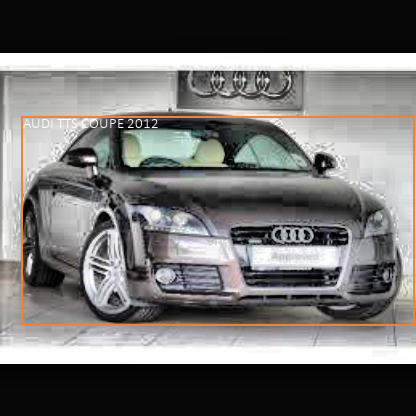

In [251]:
img_path = SSD300_jpg_img + "/03804_jpg.rf.9080d44093c44079f127734e8cde2093.jpg"
original_image = Image.open(img_path, mode="r")
original_image = original_image.convert("RGB")
detect(original_image, min_score=0.25, max_overlap=0.45, top_k=1000).show()
original_image

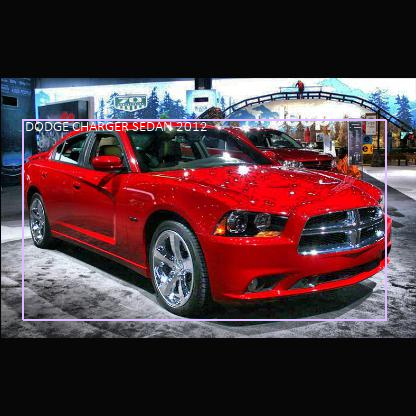

In [250]:
img_path = SSD300_jpg_img + "/00875_jpg.rf.3813bffa871fe29533319414d89f8a8f.jpg"
original_image = Image.open(img_path, mode="r")
original_image = original_image.convert("RGB")
# detect(original_image, min_score=0.2, max_overlap=0.5, top_k=200).show()
detect(original_image, min_score=0.25, max_overlap=0.45, top_k=1000).show()
original_image